In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 5
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when GHI is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 20
n_seq (number of output/future prediction time steps): 5
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     8000

C:\Users\User\AppData\Local\Temp\ipykernel_308664\3628601029.py:409: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_activity'].loc[df['Year'] > 2020] = np.nan


     file_id  specific_humidity      slp  wet_bulb_temperature  temperatures  \
0       6678              12.82  1016.20                 18.08         20.84   
1       6678              12.33  1017.48                 17.71         20.69   
2       6678              12.14  1018.26                 17.29         20.47   
3       6678              11.90  1018.41                 17.20         20.30   
4       6678              12.75  1017.92                 17.75         20.46   
..       ...                ...      ...                   ...           ...   
643     8000               5.15  1016.94                  7.64         13.02   
644     8000               5.24  1016.16                  7.88         13.47   
645     8000               5.36  1017.90                  7.13         11.84   
646     8000               5.43  1016.17                  7.66         12.86   
647     8000               5.32  1015.12                  8.11         13.58   

     water      WDSP  PRCP  SNDP  regio

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

5
20
(19, 225)
(2, 225)


[I 2025-06-06 23:20:42,413] A new study created in memory with name: no-name-07678e26-7e5c-4e39-b970-1c08b9420455
[I 2025-06-06 23:24:10,644] Trial 0 finished with value: 0.19899118021130563 and parameters: {'lr': 0.007216430880542318, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4942797587869885}. Best is trial 0 with value: 0.19899118021130563.


Cross Validation Accuracies:
[0.0447998084127903, 0.10372477769851685, 0.25933828949928284, 0.40900465846061707, 0.17808836698532104]
Mean Cross Validation Accuracy:
0.19899118021130563
Standard Deviation of Cross Validation Accuracy:
0.1273067388879207


[I 2025-06-06 23:27:56,461] Trial 1 finished with value: 0.07731717973947524 and parameters: {'lr': 0.016776554824043177, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2374809464470299}. Best is trial 1 with value: 0.07731717973947524.


Cross Validation Accuracies:
[0.06223084032535553, 0.09841343015432358, 0.0722176805138588, 0.09511184692382812, 0.05861210078001022]
Mean Cross Validation Accuracy:
0.07731717973947524
Standard Deviation of Cross Validation Accuracy:
0.016523828066872272


[I 2025-06-06 23:31:07,817] Trial 2 finished with value: 0.11196859925985336 and parameters: {'lr': 0.0017163308257759152, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4569352983164804}. Best is trial 1 with value: 0.07731717973947524.


Cross Validation Accuracies:
[0.09340838342905045, 0.12353107333183289, 0.09871029108762741, 0.15247230231761932, 0.09172094613313675]
Mean Cross Validation Accuracy:
0.11196859925985336
Standard Deviation of Cross Validation Accuracy:
0.023257139000626953


[I 2025-06-06 23:34:28,785] Trial 3 finished with value: 0.08884137123823166 and parameters: {'lr': 0.0028357604859724425, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2743825365823699}. Best is trial 1 with value: 0.07731717973947524.


Cross Validation Accuracies:
[0.06614653021097183, 0.09639233350753784, 0.08940363675355911, 0.12812310457229614, 0.06414125114679337]
Mean Cross Validation Accuracy:
0.08884137123823166
Standard Deviation of Cross Validation Accuracy:
0.023347545863387158


[I 2025-06-06 23:38:33,451] Trial 4 finished with value: 0.09294977188110351 and parameters: {'lr': 0.0012736008153807058, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.26408732285898595}. Best is trial 1 with value: 0.07731717973947524.


Cross Validation Accuracies:
[0.07589403539896011, 0.10058505088090897, 0.10194419324398041, 0.11534106731414795, 0.07098451256752014]
Mean Cross Validation Accuracy:
0.09294977188110351
Standard Deviation of Cross Validation Accuracy:
0.01681628957819769


[I 2025-06-06 23:41:56,330] Trial 5 finished with value: 0.07701094597578048 and parameters: {'lr': 0.01924771182407472, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4181415040605353}. Best is trial 5 with value: 0.07701094597578048.


Cross Validation Accuracies:
[0.06025300920009613, 0.09944755584001541, 0.0830770954489708, 0.08606640249490738, 0.05621066689491272]
Mean Cross Validation Accuracy:
0.07701094597578048
Standard Deviation of Cross Validation Accuracy:
0.01634430163219333


[I 2025-06-06 23:45:30,073] Trial 6 finished with value: 2.2267197728157044 and parameters: {'lr': 0.7396307443506904, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.29138633320690177}. Best is trial 5 with value: 0.07701094597578048.


Cross Validation Accuracies:
[2.9259541034698486, 0.7261013388633728, 3.6129400730133057, 2.081639051437378, 1.7869642972946167]
Mean Cross Validation Accuracy:
2.2267197728157044
Standard Deviation of Cross Validation Accuracy:
0.9876056245414216


[I 2025-06-06 23:48:04,257] Trial 7 finished with value: 0.10294757485389709 and parameters: {'lr': 0.7179682082201838, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.23697029663110727}. Best is trial 5 with value: 0.07701094597578048.


Cross Validation Accuracies:
[0.09360481798648834, 0.10490372031927109, 0.12571416795253754, 0.0881863683462143, 0.10232879966497421]
Mean Cross Validation Accuracy:
0.10294757485389709
Standard Deviation of Cross Validation Accuracy:
0.012866292959366057


[I 2025-06-06 23:50:45,780] Trial 8 finished with value: 0.5478739410638809 and parameters: {'lr': 0.04708270249628836, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.13666305268976275}. Best is trial 5 with value: 0.07701094597578048.


Cross Validation Accuracies:
[0.24209462106227875, 1.4347848892211914, 0.5066820383071899, 0.2472533881664276, 0.3085547685623169]
Mean Cross Validation Accuracy:
0.5478739410638809
Standard Deviation of Cross Validation Accuracy:
0.4537521743211513


[I 2025-06-06 23:54:31,984] Trial 9 finished with value: 0.07933354899287223 and parameters: {'lr': 0.021258013573011946, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3552905864705266}. Best is trial 5 with value: 0.07701094597578048.


Cross Validation Accuracies:
[0.049914684146642685, 0.10535267740488052, 0.07307589799165726, 0.09557121247053146, 0.07275327295064926]
Mean Cross Validation Accuracy:
0.07933354899287223
Standard Deviation of Cross Validation Accuracy:
0.019434940680227795


[I 2025-06-06 23:57:27,975] Trial 10 finished with value: 0.4168199568986893 and parameters: {'lr': 0.11937893461323394, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.38732447314776275}. Best is trial 5 with value: 0.07701094597578048.


Cross Validation Accuracies:
[1.721010684967041, 0.10736871510744095, 0.09775704145431519, 0.07064902782440186, 0.08731431514024734]
Mean Cross Validation Accuracy:
0.4168199568986893
Standard Deviation of Cross Validation Accuracy:
0.6522090079605256


[I 2025-06-07 00:00:08,295] Trial 11 finished with value: 0.07862201109528541 and parameters: {'lr': 0.014027690007885408, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.17446336489013026}. Best is trial 5 with value: 0.07701094597578048.


Cross Validation Accuracies:
[0.05891543999314308, 0.09755384922027588, 0.0758151039481163, 0.09501942992210388, 0.06580623239278793]
Mean Cross Validation Accuracy:
0.07862201109528541
Standard Deviation of Cross Validation Accuracy:
0.01541273301566566


[I 2025-06-07 00:03:56,944] Trial 12 finished with value: 0.0771695226430893 and parameters: {'lr': 0.0827145426631884, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.37073746075161984}. Best is trial 5 with value: 0.07701094597578048.


Cross Validation Accuracies:
[0.06387057900428772, 0.09277871996164322, 0.07299192249774933, 0.09442023187875748, 0.06178615987300873]
Mean Cross Validation Accuracy:
0.0771695226430893
Standard Deviation of Cross Validation Accuracy:
0.013944146478443093


[I 2025-06-07 00:07:38,529] Trial 13 finished with value: 0.07937570810317993 and parameters: {'lr': 0.12240606417075632, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.39467231533017716}. Best is trial 5 with value: 0.07701094597578048.


Cross Validation Accuracies:
[0.0624876543879509, 0.10506805777549744, 0.06616545468568802, 0.09294003993272781, 0.07021733373403549]
Mean Cross Validation Accuracy:
0.07937570810317993
Standard Deviation of Cross Validation Accuracy:
0.016659417183052586


[I 2025-06-07 00:10:53,099] Trial 14 finished with value: 0.07955662682652473 and parameters: {'lr': 0.07284338805817181, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.34636053643332043}. Best is trial 5 with value: 0.07701094597578048.


Cross Validation Accuracies:
[0.06026674434542656, 0.09320688992738724, 0.08667638152837753, 0.09794867783784866, 0.05968444049358368]
Mean Cross Validation Accuracy:
0.07955662682652473
Standard Deviation of Cross Validation Accuracy:
0.016384697042827325


[I 2025-06-07 00:14:35,481] Trial 15 finished with value: 0.07753570675849915 and parameters: {'lr': 0.24785595806825061, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.43020699003016366}. Best is trial 5 with value: 0.07701094597578048.


Cross Validation Accuracies:
[0.0665346309542656, 0.09364842623472214, 0.0712168961763382, 0.0948866754770279, 0.06139190495014191]
Mean Cross Validation Accuracy:
0.07753570675849915
Standard Deviation of Cross Validation Accuracy:
0.01401605662975189


[I 2025-06-07 00:17:33,441] Trial 16 finished with value: 0.21294430494308472 and parameters: {'lr': 0.007501220169912756, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3421407430479412}. Best is trial 5 with value: 0.07701094597578048.


Cross Validation Accuracies:
[0.1615150272846222, 0.2495051920413971, 0.1936311572790146, 0.26881077885627747, 0.19125936925411224]
Mean Cross Validation Accuracy:
0.21294430494308472
Standard Deviation of Cross Validation Accuracy:
0.039864686332415245


[I 2025-06-07 00:21:05,946] Trial 17 finished with value: 0.08433284685015678 and parameters: {'lr': 0.27263244323200914, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4378929851925069}. Best is trial 5 with value: 0.07701094597578048.


Cross Validation Accuracies:
[0.06294472515583038, 0.09830577671527863, 0.08936019241809845, 0.11810252815485, 0.052951011806726456]
Mean Cross Validation Accuracy:
0.08433284685015678
Standard Deviation of Cross Validation Accuracy:
0.02367775187047981


[I 2025-06-07 00:23:48,267] Trial 18 finished with value: 0.07473628595471382 and parameters: {'lr': 0.03645913883950919, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4884541732073092}. Best is trial 18 with value: 0.07473628595471382.


Cross Validation Accuracies:
[0.049596741795539856, 0.09428656846284866, 0.06209674850106239, 0.10991834849119186, 0.05778302252292633]
Mean Cross Validation Accuracy:
0.07473628595471382
Standard Deviation of Cross Validation Accuracy:
0.023234279842635246


[I 2025-06-07 00:26:25,826] Trial 19 finished with value: 0.07174279987812042 and parameters: {'lr': 0.03317878285591648, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4997537949803639}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.05883648246526718, 0.09539268910884857, 0.07002530246973038, 0.08455843478441238, 0.0499010905623436]
Mean Cross Validation Accuracy:
0.07174279987812042
Standard Deviation of Cross Validation Accuracy:
0.016553796247514452


[I 2025-06-07 00:29:22,143] Trial 20 finished with value: 1.3388291478157044 and parameters: {'lr': 0.038893259601137695, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.498944345172991}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[1.3127776384353638, 1.4087146520614624, 1.4010083675384521, 0.890646755695343, 1.6809983253479004]
Mean Cross Validation Accuracy:
1.3388291478157044
Standard Deviation of Cross Validation Accuracy:
0.25588127046339143


[I 2025-06-07 00:32:42,569] Trial 21 finished with value: 0.08221908062696456 and parameters: {'lr': 0.008235746198719711, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.46329031051347364}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.07864443957805634, 0.09450732171535492, 0.07640707492828369, 0.09633508324623108, 0.06520148366689682]
Mean Cross Validation Accuracy:
0.08221908062696456
Standard Deviation of Cross Validation Accuracy:
0.011716812485986874


[I 2025-06-07 00:36:12,806] Trial 22 finished with value: 0.07548225149512292 and parameters: {'lr': 0.028588608376962265, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4168494347813273}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06316670775413513, 0.09681802242994308, 0.0733802318572998, 0.09073193371295929, 0.05331436172127724]
Mean Cross Validation Accuracy:
0.07548225149512292
Standard Deviation of Cross Validation Accuracy:
0.016341813671361335


[I 2025-06-07 00:39:40,910] Trial 23 finished with value: 0.07793985903263093 and parameters: {'lr': 0.031890036806535044, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.47373091199010303}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.0658445730805397, 0.09364627301692963, 0.0642276480793953, 0.09774009138345718, 0.0682407096028328]
Mean Cross Validation Accuracy:
0.07793985903263093
Standard Deviation of Cross Validation Accuracy:
0.014609139690914893


[I 2025-06-07 00:42:34,979] Trial 24 finished with value: 0.24833458960056304 and parameters: {'lr': 0.004036298439150662, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4139453218553706}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.21056263148784637, 0.23141425848007202, 0.21335135400295258, 0.3795177936553955, 0.20682691037654877]
Mean Cross Validation Accuracy:
0.24833458960056304
Standard Deviation of Cross Validation Accuracy:
0.06613435666645481


[I 2025-06-07 00:45:20,916] Trial 25 finished with value: 0.07670777961611748 and parameters: {'lr': 0.05648780818227737, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.49855295970468244}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06954088807106018, 0.09395372867584229, 0.07413798570632935, 0.08746930211782455, 0.05843699350953102]
Mean Cross Validation Accuracy:
0.07670777961611748
Standard Deviation of Cross Validation Accuracy:
0.01268875821848144


[I 2025-06-07 00:48:14,615] Trial 26 finished with value: 0.08155307397246361 and parameters: {'lr': 0.22172210279886248, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4483087279441793}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.05850859358906746, 0.09785463660955429, 0.0866798534989357, 0.09563633799552917, 0.06908594816923141]
Mean Cross Validation Accuracy:
0.08155307397246361
Standard Deviation of Cross Validation Accuracy:
0.015341710727306555


[I 2025-06-07 00:51:23,471] Trial 27 finished with value: 0.07485326603055001 and parameters: {'lr': 0.01381531101786557, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3235743547365767}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.05745390057563782, 0.09726736694574356, 0.06989876925945282, 0.09521041065454483, 0.05443588271737099]
Mean Cross Validation Accuracy:
0.07485326603055001
Standard Deviation of Cross Validation Accuracy:
0.01822613373661242


[I 2025-06-07 00:54:40,831] Trial 28 finished with value: 0.10769458413124085 and parameters: {'lr': 0.011636586806980315, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.19569995514558516}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.07692167162895203, 0.16475799679756165, 0.0967775359749794, 0.13430635631084442, 0.06570935994386673]
Mean Cross Validation Accuracy:
0.10769458413124085
Standard Deviation of Cross Validation Accuracy:
0.03686009391754086


[I 2025-06-07 00:57:59,146] Trial 29 finished with value: 0.07698177471756935 and parameters: {'lr': 0.005076069877102803, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.46650685537275344}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06122841313481331, 0.09690989553928375, 0.07305341213941574, 0.09589114040136337, 0.05782601237297058]
Mean Cross Validation Accuracy:
0.07698177471756935
Standard Deviation of Cross Validation Accuracy:
0.01664474556581466


[I 2025-06-07 01:01:27,583] Trial 30 finished with value: 0.08615632951259614 and parameters: {'lr': 0.009424358018252765, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.32298372867378233}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.05967074632644653, 0.10615135729312897, 0.0795033872127533, 0.1057109385728836, 0.07974521815776825]
Mean Cross Validation Accuracy:
0.08615632951259614
Standard Deviation of Cross Validation Accuracy:
0.0177145927314429


[I 2025-06-07 01:04:16,724] Trial 31 finished with value: 0.07968686893582344 and parameters: {'lr': 0.027417157105061325, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.47272375080381934}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06215323135256767, 0.09326907992362976, 0.07137523591518402, 0.10072072595357895, 0.0709160715341568]
Mean Cross Validation Accuracy:
0.07968686893582344
Standard Deviation of Cross Validation Accuracy:
0.014699239257815314


[I 2025-06-07 01:07:55,779] Trial 32 finished with value: 0.07386524006724357 and parameters: {'lr': 0.024544253944408238, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.400517925015097}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.04958809167146683, 0.10682985931634903, 0.07190653681755066, 0.09006956219673157, 0.0509321503341198]
Mean Cross Validation Accuracy:
0.07386524006724357
Standard Deviation of Cross Validation Accuracy:
0.02221886241585351


[I 2025-06-07 01:11:39,181] Trial 33 finished with value: 0.07751737609505653 and parameters: {'lr': 0.015585957468845424, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3197947751256688}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06482569128274918, 0.10139556974172592, 0.07207347452640533, 0.09145136922597885, 0.057840775698423386]
Mean Cross Validation Accuracy:
0.07751737609505653
Standard Deviation of Cross Validation Accuracy:
0.016384186444455107


[I 2025-06-07 01:14:50,411] Trial 34 finished with value: 0.16209019124507903 and parameters: {'lr': 0.00526081698096374, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3885082046186803}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.1320957988500595, 0.09559524059295654, 0.15819399058818817, 0.28129875659942627, 0.1432671695947647]
Mean Cross Validation Accuracy:
0.16209019124507903
Standard Deviation of Cross Validation Accuracy:
0.06308947711754036


[I 2025-06-07 01:18:03,534] Trial 35 finished with value: 0.12779375165700912 and parameters: {'lr': 0.02266867977626502, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3105802945483088}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.14096106588840485, 0.13509614765644073, 0.09666652977466583, 0.11761640757322311, 0.1486286073923111]
Mean Cross Validation Accuracy:
0.12779375165700912
Standard Deviation of Cross Validation Accuracy:
0.018618682228471926


[I 2025-06-07 01:21:07,822] Trial 36 finished with value: 0.27424542903900145 and parameters: {'lr': 0.0029586303213391145, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.23805005224112394}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.21021518111228943, 0.21844041347503662, 0.25858011841773987, 0.4328904151916504, 0.251101016998291]
Mean Cross Validation Accuracy:
0.27424542903900145
Standard Deviation of Cross Validation Accuracy:
0.08144123010931936


[I 2025-06-07 01:24:34,128] Trial 37 finished with value: 0.07951758280396462 and parameters: {'lr': 0.05707065916352623, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.48036443378416643}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.07543021440505981, 0.09208562225103378, 0.08019445091485977, 0.09385797381401062, 0.056019652634859085]
Mean Cross Validation Accuracy:
0.07951758280396462
Standard Deviation of Cross Validation Accuracy:
0.01365957453923194


[I 2025-06-07 01:27:54,734] Trial 38 finished with value: 0.07762026712298394 and parameters: {'lr': 0.01196292476674184, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.4453255033099812}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06215624138712883, 0.09564565122127533, 0.06847453117370605, 0.09195373952388763, 0.06987117230892181]
Mean Cross Validation Accuracy:
0.07762026712298394
Standard Deviation of Cross Validation Accuracy:
0.013514377169583744


[I 2025-06-07 01:31:17,932] Trial 39 finished with value: 0.07874496430158615 and parameters: {'lr': 0.04034463552368867, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.273055006313093}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06969491392374039, 0.1002187505364418, 0.07248133420944214, 0.09270045906305313, 0.058629363775253296]
Mean Cross Validation Accuracy:
0.07874496430158615
Standard Deviation of Cross Validation Accuracy:
0.01537304906389991


[I 2025-06-07 01:34:37,771] Trial 40 finished with value: 0.2519988059997559 and parameters: {'lr': 0.0908665985559004, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3987465497744385}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.23308536410331726, 0.2577734589576721, 0.24207448959350586, 0.21593374013900757, 0.3111269772052765]
Mean Cross Validation Accuracy:
0.2519988059997559
Standard Deviation of Cross Validation Accuracy:
0.032515800967945305


[I 2025-06-07 01:38:25,806] Trial 41 finished with value: 0.07732613906264305 and parameters: {'lr': 0.024033781619497676, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4263202696669761}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06521954387426376, 0.09452331066131592, 0.08223424851894379, 0.09324919432401657, 0.05140439793467522]
Mean Cross Validation Accuracy:
0.07732613906264305
Standard Deviation of Cross Validation Accuracy:
0.016684617157409706


[I 2025-06-07 01:42:08,577] Trial 42 finished with value: 0.0819453552365303 and parameters: {'lr': 0.03185104135789625, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4107191575226094}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06758958101272583, 0.09888362884521484, 0.0749926045536995, 0.1013435497879982, 0.06691741198301315]
Mean Cross Validation Accuracy:
0.0819453552365303
Standard Deviation of Cross Validation Accuracy:
0.015122586675252635


[I 2025-06-07 01:45:33,249] Trial 43 finished with value: 0.0794254332780838 and parameters: {'lr': 0.01737442749354528, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3677411659354766}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06506618112325668, 0.1032840833067894, 0.07424099743366241, 0.09370045363903046, 0.060835450887680054]
Mean Cross Validation Accuracy:
0.0794254332780838
Standard Deviation of Cross Validation Accuracy:
0.016441808478656145


[I 2025-06-07 01:48:57,490] Trial 44 finished with value: 0.0770382009446621 and parameters: {'lr': 0.04532973238633117, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.48444934072320556}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.054856400936841965, 0.10479652136564255, 0.06644164025783539, 0.09469375014305115, 0.06440269201993942]
Mean Cross Validation Accuracy:
0.0770382009446621
Standard Deviation of Cross Validation Accuracy:
0.01921571339218939


[I 2025-06-07 01:52:23,811] Trial 45 finished with value: 0.08686928302049637 and parameters: {'lr': 0.017979065291624054, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.3661716586735544}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06427840143442154, 0.10058517009019852, 0.0977068692445755, 0.09991389513015747, 0.07186207920312881]
Mean Cross Validation Accuracy:
0.08686928302049637
Standard Deviation of Cross Validation Accuracy:
0.015564734727047265


[I 2025-06-07 01:55:55,381] Trial 46 finished with value: 0.36045001745224 and parameters: {'lr': 0.0017182389308763471, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.28934462460492166}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.31773534417152405, 0.32324692606925964, 0.3227943480014801, 0.5085394382476807, 0.3299340307712555]
Mean Cross Validation Accuracy:
0.36045001745224
Standard Deviation of Cross Validation Accuracy:
0.07414615938584641


[I 2025-06-07 01:59:13,326] Trial 47 finished with value: 0.08189247995615005 and parameters: {'lr': 0.1530212919823819, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.45355209063523705}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06287512183189392, 0.09764467179775238, 0.08760926127433777, 0.09110657125711441, 0.0702267736196518]
Mean Cross Validation Accuracy:
0.08189247995615005
Standard Deviation of Cross Validation Accuracy:
0.013141242173499096


[I 2025-06-07 02:02:37,812] Trial 48 finished with value: 0.0753595121204853 and parameters: {'lr': 0.06618562190419819, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.32953849099724775}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06264153122901917, 0.10034241527318954, 0.07604896277189255, 0.09194612503051758, 0.045818526297807693]
Mean Cross Validation Accuracy:
0.0753595121204853
Standard Deviation of Cross Validation Accuracy:
0.019668011599023996


[I 2025-06-07 02:06:12,593] Trial 49 finished with value: 0.07562036365270615 and parameters: {'lr': 0.06704429694021441, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3352837288698292}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.058950379490852356, 0.09702655673027039, 0.07273548096418381, 0.0943618044257164, 0.05502759665250778]
Mean Cross Validation Accuracy:
0.07562036365270615
Standard Deviation of Cross Validation Accuracy:
0.017434102656171676


[I 2025-06-07 02:10:04,349] Trial 50 finished with value: 12.497642517089844 and parameters: {'lr': 0.11350450461492985, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2851759615933514}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[11.399752616882324, 11.58769702911377, 13.065495491027832, 12.839818954467773, 13.59544849395752]
Mean Cross Validation Accuracy:
12.497642517089844
Standard Deviation of Cross Validation Accuracy:
0.8576809081726088


[I 2025-06-07 02:13:25,997] Trial 51 finished with value: 0.07640867829322814 and parameters: {'lr': 0.034188116433249316, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.24757216565684367}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.05677756294608116, 0.09512259066104889, 0.07318204641342163, 0.10289213061332703, 0.05406906083226204]
Mean Cross Validation Accuracy:
0.07640867829322814
Standard Deviation of Cross Validation Accuracy:
0.01973035283143462


[I 2025-06-07 02:18:02,419] Trial 52 finished with value: 0.07578418701887131 and parameters: {'lr': 0.054628651089556876, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3046613424638117}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.055845893919467926, 0.09615930169820786, 0.07192300260066986, 0.0924919843673706, 0.06250075250864029]
Mean Cross Validation Accuracy:
0.07578418701887131
Standard Deviation of Cross Validation Accuracy:
0.016019923218613192


[I 2025-06-07 02:21:24,203] Trial 53 finished with value: 0.07887321785092354 and parameters: {'lr': 0.024204330106655146, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.37531296956404187}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.05104036256670952, 0.10300178080797195, 0.07918860018253326, 0.097730852663517, 0.06340449303388596]
Mean Cross Validation Accuracy:
0.07887321785092354
Standard Deviation of Cross Validation Accuracy:
0.019757766512689193


[I 2025-06-07 02:25:22,446] Trial 54 finished with value: 0.08096572309732437 and parameters: {'lr': 0.012537764913461613, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4026419901254704}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06002766638994217, 0.10213115066289902, 0.0813736692070961, 0.09836503863334656, 0.06293109059333801]
Mean Cross Validation Accuracy:
0.08096572309732437
Standard Deviation of Cross Validation Accuracy:
0.017404184056826807


[I 2025-06-07 02:29:17,680] Trial 55 finished with value: 0.15926646292209626 and parameters: {'lr': 0.044090437335205866, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.10601350830736186}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.1433478593826294, 0.196148082613945, 0.16259491443634033, 0.12435120344161987, 0.16989025473594666]
Mean Cross Validation Accuracy:
0.15926646292209626
Standard Deviation of Cross Validation Accuracy:
0.024317379366685862


[I 2025-06-07 02:33:25,741] Trial 56 finished with value: 0.0758072279393673 and parameters: {'lr': 0.45982262609054564, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.34794214815374014}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.05434222146868706, 0.09900887310504913, 0.06950127333402634, 0.09791839867830276, 0.05826537311077118]
Mean Cross Validation Accuracy:
0.0758072279393673
Standard Deviation of Cross Validation Accuracy:
0.01915958479163403


[I 2025-06-07 02:36:47,871] Trial 57 finished with value: 0.07994451820850372 and parameters: {'lr': 0.08418955560041314, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4340108117948744}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.0544089674949646, 0.09997466951608658, 0.06956636160612106, 0.11313173174858093, 0.06264086067676544]
Mean Cross Validation Accuracy:
0.07994451820850372
Standard Deviation of Cross Validation Accuracy:
0.0226353049577086


[I 2025-06-07 02:39:43,935] Trial 58 finished with value: 0.07929477542638778 and parameters: {'lr': 0.028990439705636556, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.48710069985430104}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.061006709933280945, 0.0985221117734909, 0.07288513332605362, 0.09039394557476044, 0.07366597652435303]
Mean Cross Validation Accuracy:
0.07929477542638778
Standard Deviation of Cross Validation Accuracy:
0.013417170114455944


[I 2025-06-07 02:43:09,515] Trial 59 finished with value: 0.08006485030055047 and parameters: {'lr': 0.010076194143621445, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3302318242490773}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.07016225159168243, 0.10387765616178513, 0.0744873434305191, 0.09947826713323593, 0.05231873318552971]
Mean Cross Validation Accuracy:
0.08006485030055047
Standard Deviation of Cross Validation Accuracy:
0.01919868503381946


[I 2025-06-07 02:46:30,868] Trial 60 finished with value: 0.07607311829924583 and parameters: {'lr': 0.014805974978646906, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.38255214623590367}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.05106246843934059, 0.10066095739603043, 0.07834380865097046, 0.08872447162866592, 0.06157388538122177]
Mean Cross Validation Accuracy:
0.07607311829924583
Standard Deviation of Cross Validation Accuracy:
0.01791945852315021


[I 2025-06-07 02:50:03,974] Trial 61 finished with value: 0.07610142529010773 and parameters: {'lr': 0.07104152707172924, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3318552834806876}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06070441007614136, 0.09640584886074066, 0.07405616343021393, 0.0920671746134758, 0.05727352946996689]
Mean Cross Validation Accuracy:
0.07610142529010773
Standard Deviation of Cross Validation Accuracy:
0.015892863823622393


[I 2025-06-07 02:53:08,873] Trial 62 finished with value: 0.07672452032566071 and parameters: {'lr': 0.05915136653434307, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.33551510382745897}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.059567876160144806, 0.09633447974920273, 0.07377565652132034, 0.09333184361457825, 0.060612745583057404]
Mean Cross Validation Accuracy:
0.07672452032566071
Standard Deviation of Cross Validation Accuracy:
0.01563962414849319


[I 2025-06-07 02:56:21,062] Trial 63 finished with value: 0.07744175046682358 and parameters: {'lr': 0.17872264049977737, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4598790714520313}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06056748330593109, 0.09779097884893417, 0.0715733990073204, 0.09592673182487488, 0.06135015934705734]
Mean Cross Validation Accuracy:
0.07744175046682358
Standard Deviation of Cross Validation Accuracy:
0.0163334220382011


[I 2025-06-07 02:59:52,557] Trial 64 finished with value: 0.07635144144296646 and parameters: {'lr': 0.035521709360079506, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.35606156140465917}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.05834948271512985, 0.09691547602415085, 0.07295449823141098, 0.09987856447696686, 0.05365918576717377]
Mean Cross Validation Accuracy:
0.07635144144296646
Standard Deviation of Cross Validation Accuracy:
0.019115194194095703


[I 2025-06-07 03:03:18,721] Trial 65 finished with value: 0.1920021504163742 and parameters: {'lr': 0.0703667353933448, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.357009027059081}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.16501650214195251, 0.1576835960149765, 0.15226195752620697, 0.19148452579975128, 0.29356417059898376]
Mean Cross Validation Accuracy:
0.1920021504163742
Standard Deviation of Cross Validation Accuracy:
0.05253643154755891


[I 2025-06-07 03:07:04,785] Trial 66 finished with value: 0.07758401930332184 and parameters: {'lr': 0.02001393519188377, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.42041620800930873}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.05820155888795853, 0.10080225020647049, 0.07537531852722168, 0.0909787192940712, 0.0625622496008873]
Mean Cross Validation Accuracy:
0.07758401930332184
Standard Deviation of Cross Validation Accuracy:
0.01627707547428935


[I 2025-06-07 03:10:13,596] Trial 67 finished with value: 0.07973365187644958 and parameters: {'lr': 0.09764880289550314, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2069319868290004}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.060036249458789825, 0.09795034676790237, 0.07265609502792358, 0.09527699649333954, 0.0727485716342926]
Mean Cross Validation Accuracy:
0.07973365187644958
Standard Deviation of Cross Validation Accuracy:
0.014562378607798944


[I 2025-06-07 03:13:47,021] Trial 68 finished with value: 0.0768446035683155 and parameters: {'lr': 0.05062332158418774, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3091674049734793}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.05888286605477333, 0.10131150484085083, 0.07284632325172424, 0.08848939836025238, 0.06269292533397675]
Mean Cross Validation Accuracy:
0.0768446035683155
Standard Deviation of Cross Validation Accuracy:
0.015956884159948004


[I 2025-06-07 03:17:04,513] Trial 69 finished with value: 0.09482399672269821 and parameters: {'lr': 0.026054548704229404, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.49701776565722655}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.07573076337575912, 0.1081281527876854, 0.08805441111326218, 0.12848490476608276, 0.0737217515707016]
Mean Cross Validation Accuracy:
0.09482399672269821
Standard Deviation of Cross Validation Accuracy:
0.020812212272249393


[I 2025-06-07 03:20:17,668] Trial 70 finished with value: 0.0774556927382946 and parameters: {'lr': 0.04076248163625542, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.44051729642001825}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06019245833158493, 0.09276732057332993, 0.07847676426172256, 0.0944366604089737, 0.06140526011586189]
Mean Cross Validation Accuracy:
0.0774556927382946
Standard Deviation of Cross Validation Accuracy:
0.014693382500945719


[I 2025-06-07 03:24:24,032] Trial 71 finished with value: 0.07819382399320603 and parameters: {'lr': 0.06322210333610874, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3125467247196519}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.05640072375535965, 0.09858332574367523, 0.07576943188905716, 0.09403577446937561, 0.06617986410856247]
Mean Cross Validation Accuracy:
0.07819382399320603
Standard Deviation of Cross Validation Accuracy:
0.01607389998527489


[I 2025-06-07 03:28:55,399] Trial 72 finished with value: 0.07848701253533363 and parameters: {'lr': 0.13489756305745734, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2989627257953476}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.057068757712841034, 0.09557568281888962, 0.07082425802946091, 0.10869616270065308, 0.06027020141482353]
Mean Cross Validation Accuracy:
0.07848701253533363
Standard Deviation of Cross Validation Accuracy:
0.0202678418161863


[I 2025-06-07 03:33:17,675] Trial 73 finished with value: 0.07700981870293618 and parameters: {'lr': 0.020406683164783453, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2651806763500786}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.059943974018096924, 0.09729787707328796, 0.07216329872608185, 0.09377756714820862, 0.06186637654900551]
Mean Cross Validation Accuracy:
0.07700981870293618
Standard Deviation of Cross Validation Accuracy:
0.015727799282323554


[I 2025-06-07 03:37:14,081] Trial 74 finished with value: 0.07738037630915642 and parameters: {'lr': 0.05054440493043908, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.29960499936770163}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06004777178168297, 0.09705357253551483, 0.0752212256193161, 0.09396973252296448, 0.06060957908630371]
Mean Cross Validation Accuracy:
0.07738037630915642
Standard Deviation of Cross Validation Accuracy:
0.015802418424068453


[I 2025-06-07 03:40:42,196] Trial 75 finished with value: 0.08293996080756187 and parameters: {'lr': 0.006206741258820106, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.28082026669642224}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.04984475299715996, 0.09541279822587967, 0.09293452650308609, 0.10141810774803162, 0.07508961856365204]
Mean Cross Validation Accuracy:
0.08293996080756187
Standard Deviation of Cross Validation Accuracy:
0.018728724379517857


[I 2025-06-07 03:43:19,002] Trial 76 finished with value: 0.07617352604866028 and parameters: {'lr': 0.030973450883806146, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.34526859923098707}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.07029322534799576, 0.09615620970726013, 0.06840059906244278, 0.08763927221298218, 0.058378323912620544]
Mean Cross Validation Accuracy:
0.07617352604866028
Standard Deviation of Cross Validation Accuracy:
0.013729067926339013


[I 2025-06-07 03:46:24,695] Trial 77 finished with value: 0.07922604233026505 and parameters: {'lr': 0.03718770332190028, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3173113634222921}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.0703781321644783, 0.10017275810241699, 0.08470731228590012, 0.0833379477262497, 0.05753406137228012]
Mean Cross Validation Accuracy:
0.07922604233026505
Standard Deviation of Cross Validation Accuracy:
0.014384328556695355


[I 2025-06-07 03:48:55,159] Trial 78 finished with value: 0.19817613661289216 and parameters: {'lr': 0.10914221740576184, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2526520703678174}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.20962631702423096, 0.22265450656414032, 0.18352091312408447, 0.1925707906484604, 0.18250815570354462]
Mean Cross Validation Accuracy:
0.19817613661289216
Standard Deviation of Cross Validation Accuracy:
0.01563315919183277


[I 2025-06-07 03:52:19,421] Trial 79 finished with value: 0.07782841697335244 and parameters: {'lr': 0.08204158669255525, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4749124754124883}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06752832978963852, 0.0969119593501091, 0.07203450053930283, 0.0966566726565361, 0.05601062253117561]
Mean Cross Validation Accuracy:
0.07782841697335244
Standard Deviation of Cross Validation Accuracy:
0.01633623101988182


[I 2025-06-07 03:54:51,565] Trial 80 finished with value: 0.07789698168635369 and parameters: {'lr': 0.05136819491380011, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3234193671300753}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.05991016700863838, 0.10130172967910767, 0.0775754302740097, 0.09321533143520355, 0.05748225003480911]
Mean Cross Validation Accuracy:
0.07789698168635369
Standard Deviation of Cross Validation Accuracy:
0.017451786347524662


[I 2025-06-07 03:57:52,356] Trial 81 finished with value: 0.07647543400526047 and parameters: {'lr': 0.46680750602482557, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.34742061895672677}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.058187566697597504, 0.09366004168987274, 0.07271870225667953, 0.09978713095188141, 0.05802372843027115]
Mean Cross Validation Accuracy:
0.07647543400526047
Standard Deviation of Cross Validation Accuracy:
0.017480105940895822


[I 2025-06-07 04:00:47,538] Trial 82 finished with value: 0.10394293665885926 and parameters: {'lr': 0.9899034686317765, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3818266168272865}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.1197488084435463, 0.13622482120990753, 0.08911637961864471, 0.07716648280620575, 0.09745819121599197]
Mean Cross Validation Accuracy:
0.10394293665885926
Standard Deviation of Cross Validation Accuracy:
0.021311043386422833


[I 2025-06-07 04:03:49,533] Trial 83 finished with value: 0.07561688050627709 and parameters: {'lr': 0.3600016732059899, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.36080351905641667}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.051816340535879135, 0.09710515290498734, 0.07273858785629272, 0.09183960407972336, 0.06458471715450287]
Mean Cross Validation Accuracy:
0.07561688050627709
Standard Deviation of Cross Validation Accuracy:
0.016860495310063207


[I 2025-06-07 04:07:12,272] Trial 84 finished with value: 0.08597720563411712 and parameters: {'lr': 0.33950267217513724, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4068034639859624}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.07027339190244675, 0.10727418959140778, 0.07744232565164566, 0.11075539141893387, 0.06414072960615158]
Mean Cross Validation Accuracy:
0.08597720563411712
Standard Deviation of Cross Validation Accuracy:
0.0193070227835267


[I 2025-06-07 04:10:03,975] Trial 85 finished with value: 0.07947518900036812 and parameters: {'lr': 0.01432734573887768, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3631750015112756}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06219251826405525, 0.09991098195314407, 0.08521773666143417, 0.09599267691373825, 0.05406203120946884]
Mean Cross Validation Accuracy:
0.07947518900036812
Standard Deviation of Cross Validation Accuracy:
0.01826442000667758


[I 2025-06-07 04:11:59,404] Trial 86 finished with value: 0.08153727948665619 and parameters: {'lr': 0.017474862594848508, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3953840723251199}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.05759343504905701, 0.09765857458114624, 0.06457321345806122, 0.11427439004182816, 0.07358678430318832]
Mean Cross Validation Accuracy:
0.08153727948665619
Standard Deviation of Cross Validation Accuracy:
0.02124105533800995


[I 2025-06-07 04:13:59,728] Trial 87 finished with value: 0.09114496856927871 and parameters: {'lr': 0.009408283241791734, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.33595557376033547}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06380634009838104, 0.1011650413274765, 0.08219267427921295, 0.145276740193367, 0.06328404694795609]
Mean Cross Validation Accuracy:
0.09114496856927871
Standard Deviation of Cross Validation Accuracy:
0.03044478835714655


[I 2025-06-07 04:16:16,845] Trial 88 finished with value: 0.07733682841062546 and parameters: {'lr': 0.027243406855580105, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.37733376617719677}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06601863354444504, 0.1023368164896965, 0.06738216429948807, 0.09420947730541229, 0.05673705041408539]
Mean Cross Validation Accuracy:
0.07733682841062546
Standard Deviation of Cross Validation Accuracy:
0.017670503166472548


[I 2025-06-07 04:18:24,342] Trial 89 finished with value: 0.07798212766647339 and parameters: {'lr': 0.021576447811876544, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.42344698756304966}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06394754350185394, 0.09645382314920425, 0.07135510444641113, 0.09926937520503998, 0.058884792029857635]
Mean Cross Validation Accuracy:
0.07798212766647339
Standard Deviation of Cross Validation Accuracy:
0.016732875781679216


[I 2025-06-07 04:20:20,321] Trial 90 finished with value: 0.07773237079381942 and parameters: {'lr': 0.040895950038019525, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3908311021367363}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06158244237303734, 0.10006873309612274, 0.07315660268068314, 0.0954819917678833, 0.05837208405137062]
Mean Cross Validation Accuracy:
0.07773237079381942
Standard Deviation of Cross Validation Accuracy:
0.017149581162198124


[I 2025-06-07 04:23:04,200] Trial 91 finished with value: 0.08000738769769669 and parameters: {'lr': 0.494762363241231, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3060604159010176}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06554587185382843, 0.09815250337123871, 0.07079634815454483, 0.09704934060573578, 0.06849287450313568]
Mean Cross Validation Accuracy:
0.08000738769769669
Standard Deviation of Cross Validation Accuracy:
0.01446537995215972


[I 2025-06-07 04:25:24,983] Trial 92 finished with value: 0.07784619927406311 and parameters: {'lr': 0.3236031329721825, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.34182956465608705}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.07117141038179398, 0.09548246115446091, 0.06732182204723358, 0.08818265050649643, 0.06707265228033066]
Mean Cross Validation Accuracy:
0.07784619927406311
Standard Deviation of Cross Validation Accuracy:
0.011741078270666403


[I 2025-06-07 04:27:47,055] Trial 93 finished with value: 0.07935435548424721 and parameters: {'lr': 0.6011289127337789, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3228582295803423}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.07128641754388809, 0.09441950172185898, 0.08359862864017487, 0.0893208235502243, 0.0581464059650898]
Mean Cross Validation Accuracy:
0.07935435548424721
Standard Deviation of Cross Validation Accuracy:
0.013108559927844954


[I 2025-06-07 04:30:09,778] Trial 94 finished with value: 0.07731232792139053 and parameters: {'lr': 0.21699440608591555, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.35023316793864956}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.05505215376615524, 0.10018159449100494, 0.07206813246011734, 0.09822677075862885, 0.061032988131046295]
Mean Cross Validation Accuracy:
0.07731232792139053
Standard Deviation of Cross Validation Accuracy:
0.018700005968400765


[I 2025-06-07 04:32:23,012] Trial 95 finished with value: 0.0803858458995819 and parameters: {'lr': 0.44869284091580197, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3633510116717601}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06691193580627441, 0.09733235836029053, 0.07788947224617004, 0.10517293214797974, 0.054622530937194824]
Mean Cross Validation Accuracy:
0.0803858458995819
Standard Deviation of Cross Validation Accuracy:
0.018724905669923176


[I 2025-06-07 04:34:00,843] Trial 96 finished with value: 2.7975363731384277 and parameters: {'lr': 0.6410848068180108, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3289974156548438}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[2.5499939918518066, 2.5064966678619385, 2.7267796993255615, 2.0737648010253906, 4.130646705627441]
Mean Cross Validation Accuracy:
2.7975363731384277
Standard Deviation of Cross Validation Accuracy:
0.7002879828552655


[I 2025-06-07 04:35:45,220] Trial 97 finished with value: 0.08134849816560745 and parameters: {'lr': 0.031515029787631474, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.48777152481013}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.0569504052400589, 0.10019709169864655, 0.07646941393613815, 0.10391359776258469, 0.06921198219060898]
Mean Cross Validation Accuracy:
0.08134849816560745
Standard Deviation of Cross Validation Accuracy:
0.01806001450347467


[I 2025-06-07 04:38:33,926] Trial 98 finished with value: 0.08267828598618507 and parameters: {'lr': 0.05706353944783962, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.45232586277976833}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.07836142182350159, 0.09701535105705261, 0.08211047202348709, 0.09705943614244461, 0.05884474888443947]
Mean Cross Validation Accuracy:
0.08267828598618507
Standard Deviation of Cross Validation Accuracy:
0.014137638659541088


[I 2025-06-07 04:40:51,475] Trial 99 finished with value: 0.07894778326153755 and parameters: {'lr': 0.16630005942916506, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3539301501262812}. Best is trial 19 with value: 0.07174279987812042.


Cross Validation Accuracies:
[0.06824944913387299, 0.10158330202102661, 0.06935767829418182, 0.10881151258945465, 0.04673697426915169]
Mean Cross Validation Accuracy:
0.07894778326153755
Standard Deviation of Cross Validation Accuracy:
0.023013777270227923
Number of finished trials: 100
Best trial: {'lr': 0.03317878285591648, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4997537949803639}
Best hyperparameters:  {'lr': 0.03317878285591648, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4997537949803639}
Fold 1:
Epoch 1/100
19/19 [==============================] - 21s 280ms/step - loss: 0.2936 - val_loss: 0.1350
Epoch 2/100
19/19 [==============================] - 1s 26ms/step - loss: 0.0937 - val_loss: 0.0528
Epoch 3/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0904 - val_loss: 0.0581
Epoch 4/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0803 - val_loss: 0.0625

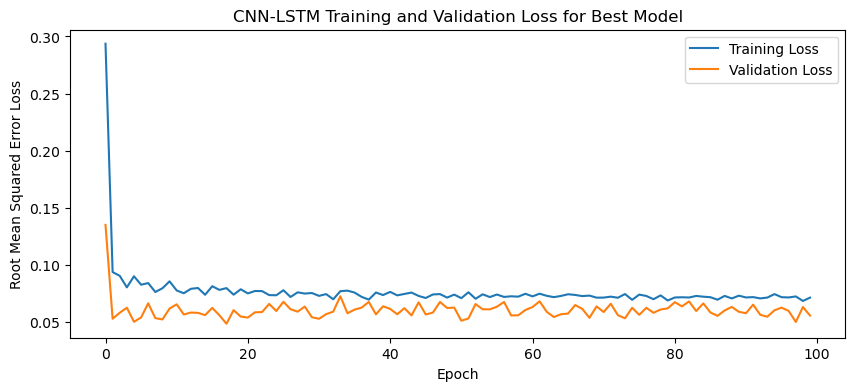

1/1 - 4s - loss: 0.0595 - 4s/epoch - 4s/step
Test Loss: 0.05951997637748718
Fold 2:
Epoch 1/100
19/19 [==============================] - 11s 155ms/step - loss: 0.3284 - val_loss: 0.1872
Epoch 2/100
19/19 [==============================] - 0s 10ms/step - loss: 0.0961 - val_loss: 0.0614
Epoch 3/100
19/19 [==============================] - 0s 11ms/step - loss: 0.0729 - val_loss: 0.0545
Epoch 4/100
19/19 [==============================] - 0s 11ms/step - loss: 0.0742 - val_loss: 0.0586
Epoch 5/100
19/19 [==============================] - 0s 11ms/step - loss: 0.0732 - val_loss: 0.0613
Epoch 6/100
19/19 [==============================] - 0s 11ms/step - loss: 0.0692 - val_loss: 0.0612
Epoch 7/100
19/19 [==============================] - 0s 10ms/step - loss: 0.0738 - val_loss: 0.0580
Epoch 8/100
19/19 [==============================] - 0s 10ms/step - loss: 0.0751 - val_loss: 0.0579
Epoch 9/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0766 - val_loss: 0.0598
Epoch 10/100
19

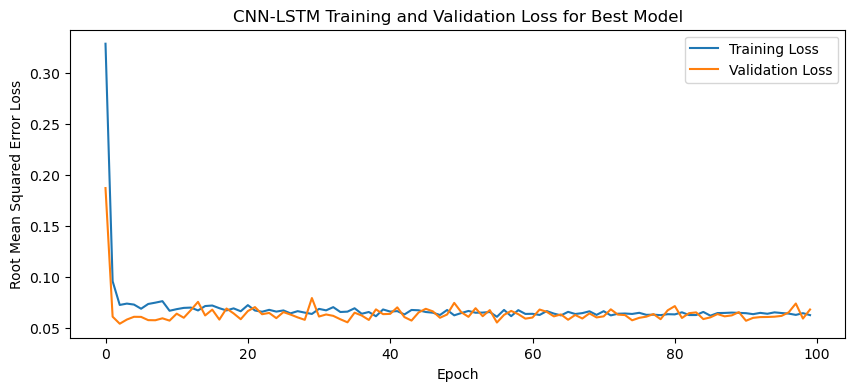

1/1 - 4s - loss: 0.0933 - 4s/epoch - 4s/step
Test Loss: 0.09333071857690811
Fold 3:
Epoch 1/100
19/19 [==============================] - 25s 366ms/step - loss: 0.3208 - val_loss: 0.1566
Epoch 2/100
19/19 [==============================] - 0s 22ms/step - loss: 0.0905 - val_loss: 0.0701
Epoch 3/100
19/19 [==============================] - 0s 26ms/step - loss: 0.0816 - val_loss: 0.0641
Epoch 4/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0849 - val_loss: 0.0693
Epoch 5/100
19/19 [==============================] - 0s 25ms/step - loss: 0.0853 - val_loss: 0.0745
Epoch 6/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0741 - val_loss: 0.0621
Epoch 7/100
19/19 [==============================] - 0s 22ms/step - loss: 0.0837 - val_loss: 0.0687
Epoch 8/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0744 - val_loss: 0.0637
Epoch 9/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0796 - val_loss: 0.0795
Epoch 10/100
1

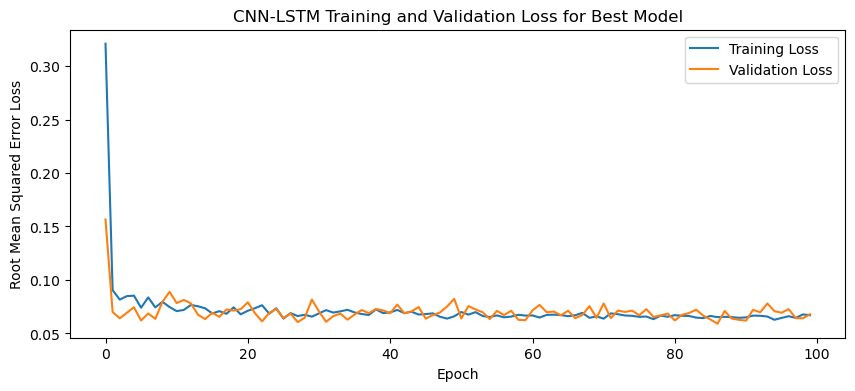

1/1 - 2s - loss: 0.0746 - 2s/epoch - 2s/step
Test Loss: 0.07461756467819214
Fold 4:
Epoch 1/100
20/20 [==============================] - 7s 121ms/step - loss: 0.4105 - val_loss: 0.1779
Epoch 2/100
20/20 [==============================] - 0s 9ms/step - loss: 0.1211 - val_loss: 0.0745
Epoch 3/100
20/20 [==============================] - 0s 9ms/step - loss: 0.1079 - val_loss: 0.0736
Epoch 4/100
20/20 [==============================] - 0s 9ms/step - loss: 0.1148 - val_loss: 0.0815
Epoch 5/100
20/20 [==============================] - 0s 9ms/step - loss: 0.1118 - val_loss: 0.0673
Epoch 6/100
20/20 [==============================] - 0s 9ms/step - loss: 0.1066 - val_loss: 0.0787
Epoch 7/100
20/20 [==============================] - 0s 8ms/step - loss: 0.1159 - val_loss: 0.0774
Epoch 8/100
20/20 [==============================] - 0s 9ms/step - loss: 0.1157 - val_loss: 0.0768
Epoch 9/100
20/20 [==============================] - 0s 10ms/step - loss: 0.1126 - val_loss: 0.0594
Epoch 10/100
20/20 [==

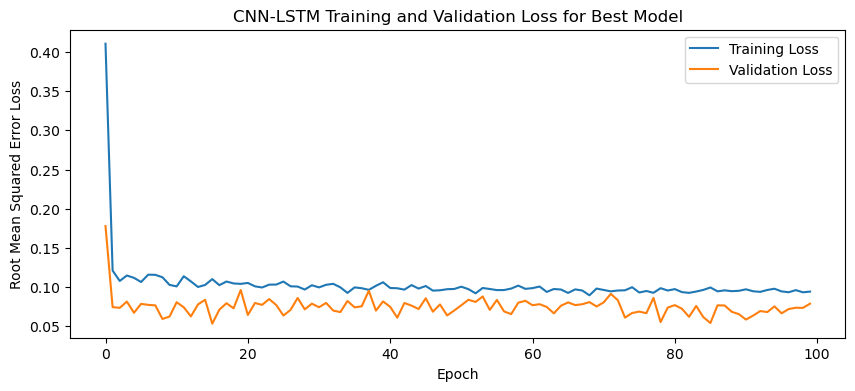

1/1 - 5s - loss: 0.1056 - 5s/epoch - 5s/step
Test Loss: 0.10563565045595169
Fold 5:
Epoch 1/100
19/19 [==============================] - 24s 372ms/step - loss: 0.3406 - val_loss: 0.2264
Epoch 2/100
19/19 [==============================] - 0s 22ms/step - loss: 0.1272 - val_loss: 0.0752
Epoch 3/100
19/19 [==============================] - 1s 29ms/step - loss: 0.0763 - val_loss: 0.0764
Epoch 4/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0824 - val_loss: 0.0729
Epoch 5/100
19/19 [==============================] - 0s 26ms/step - loss: 0.0762 - val_loss: 0.0883
Epoch 6/100
19/19 [==============================] - 0s 19ms/step - loss: 0.0740 - val_loss: 0.0883
Epoch 7/100
19/19 [==============================] - 1s 30ms/step - loss: 0.0772 - val_loss: 0.0785
Epoch 8/100
19/19 [==============================] - 0s 19ms/step - loss: 0.0736 - val_loss: 0.0866
Epoch 9/100
19/19 [==============================] - 1s 31ms/step - loss: 0.0759 - val_loss: 0.0821
Epoch 10/100
1

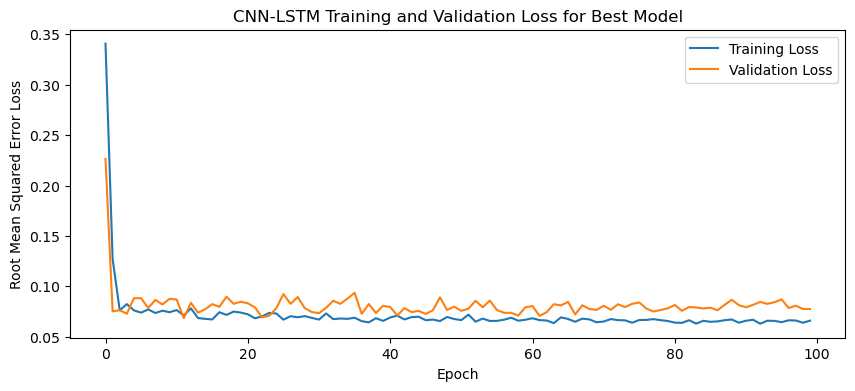

1/1 - 2s - loss: 0.0542 - 2s/epoch - 2s/step
Test Loss: 0.054192136973142624


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

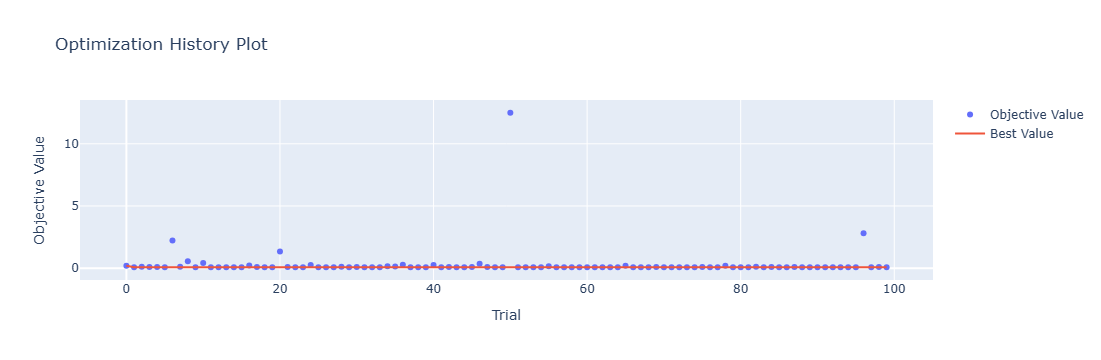

In [4]:
optuna.visualization.plot_optimization_history(study)

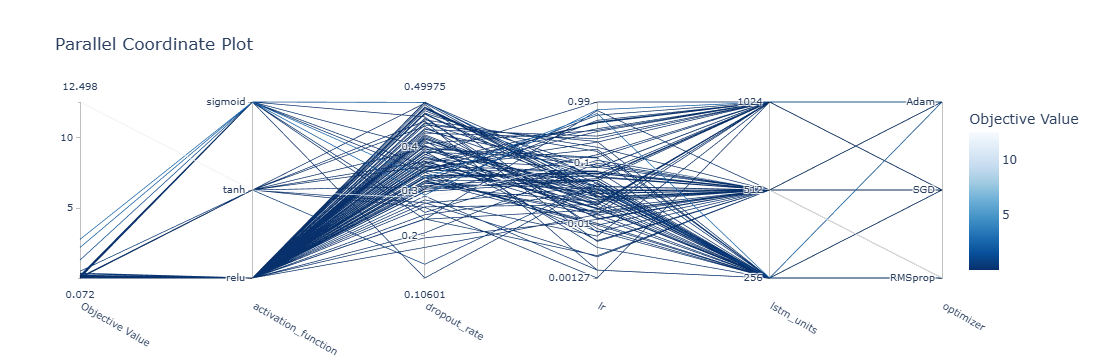

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

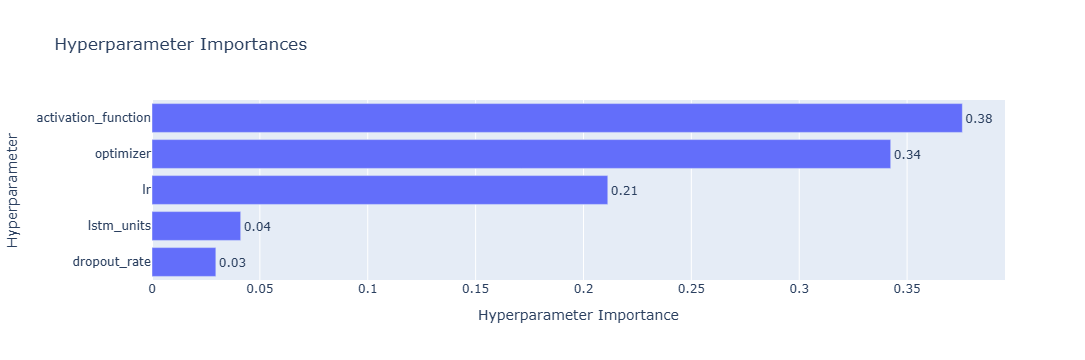

In [6]:
optuna.visualization.plot_param_importances(study)

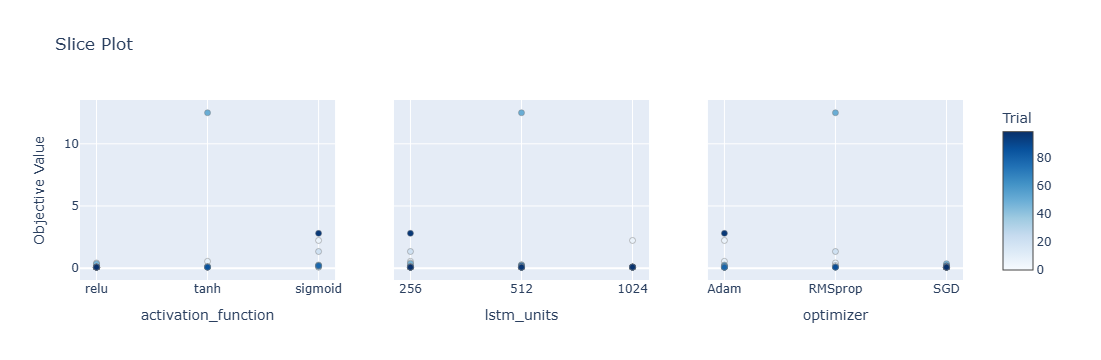

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

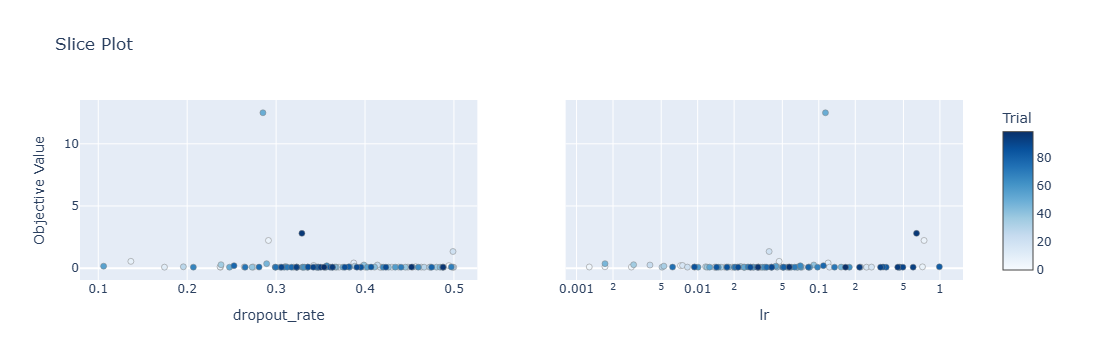

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 6s 90ms/step - loss: 0.3130 - accuracy: 0.2632 - mae: 0.2969 - rmse: 0.3130 - mape: 71.6058 - pearson: 0.2799 - val_loss: 0.1804 - val_accuracy: 0.6667 - val_mae: 0.1719 - val_rmse: 0.1804 - val_mape: 39.7724 - val_pearson: 0.5115
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1082 - accuracy: 0.3684 - mae: 0.0924 - rmse: 0.1082 - mape: 22.6210 - pearson: 0.3219 - val_loss: 0.0579 - val_accuracy: 0.6667 - val_mae: 0.0524 - val_rmse: 0.0579 - val_mape: 12.9621 - val_pearson: 0.3835
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0838 - accuracy: 0.

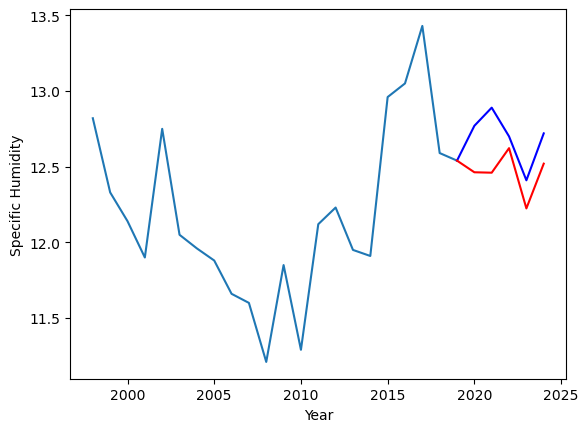

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.88		9.71		-0.17
10.09		9.71		-0.38
9.65		9.87		0.22
9.13		9.47		0.34
9.32		9.77		0.45


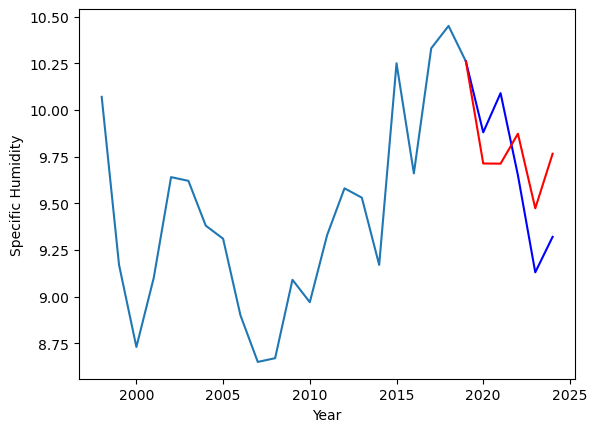

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.77  12.463050
1                1    9.88   9.713011


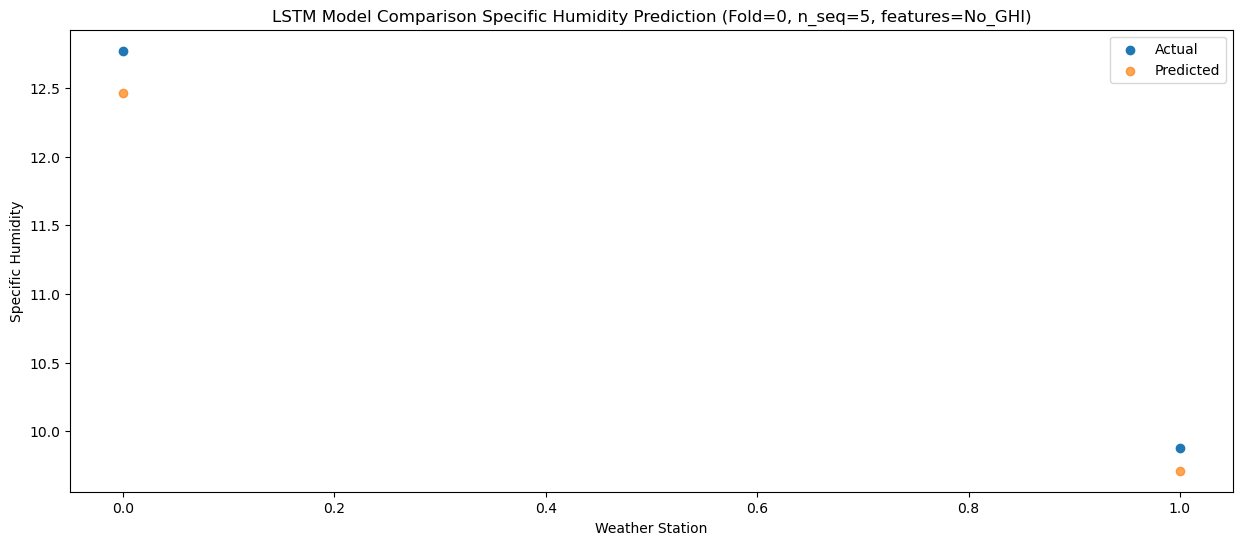

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.89  12.460286
1                1   10.09   9.712109


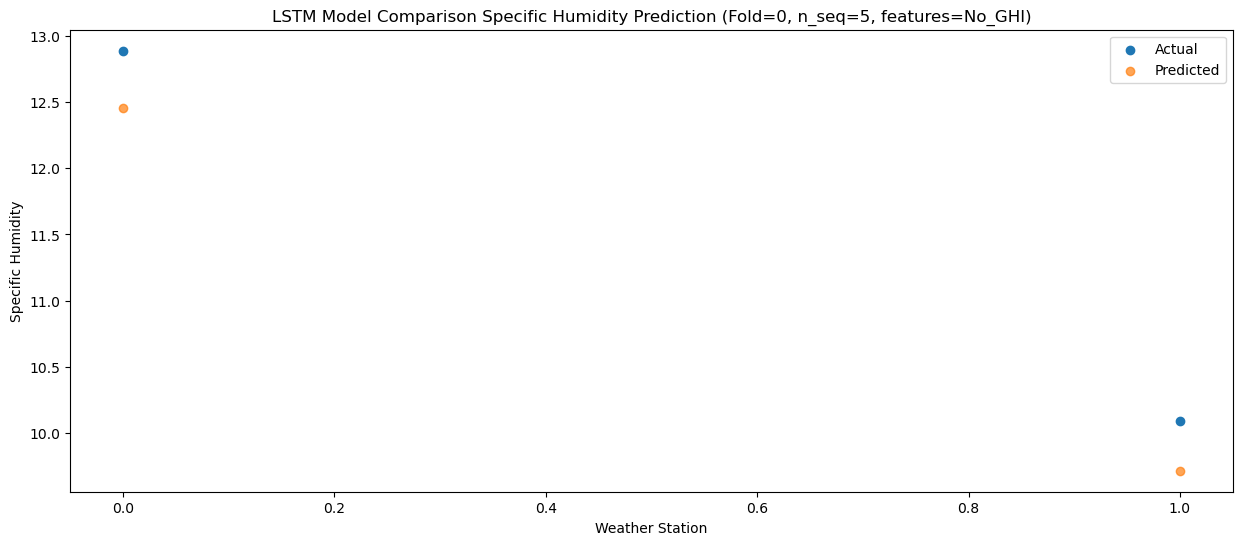

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   12.70  12.622448
1                1    9.65   9.872448


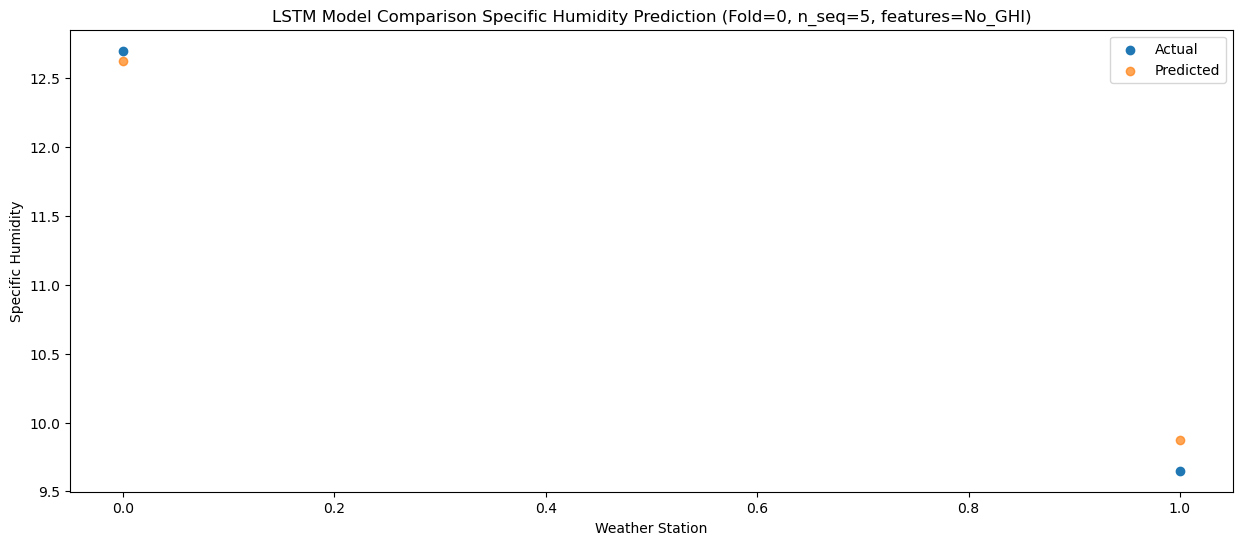

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.41  12.224244
1                1    9.13   9.472710


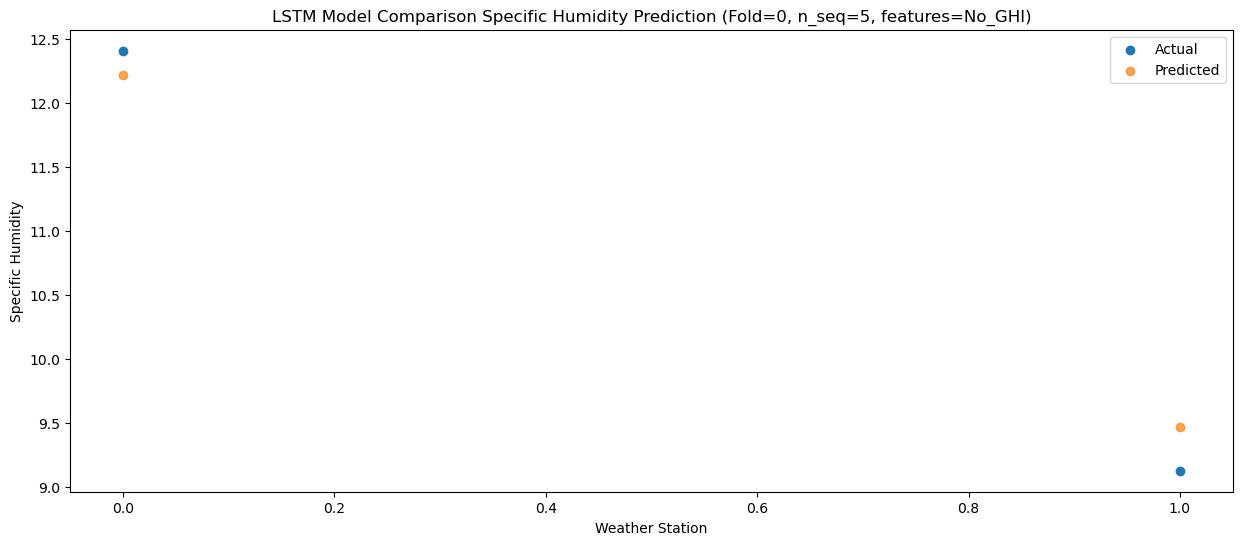

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   12.72  12.519914
1                1    9.32   9.765102


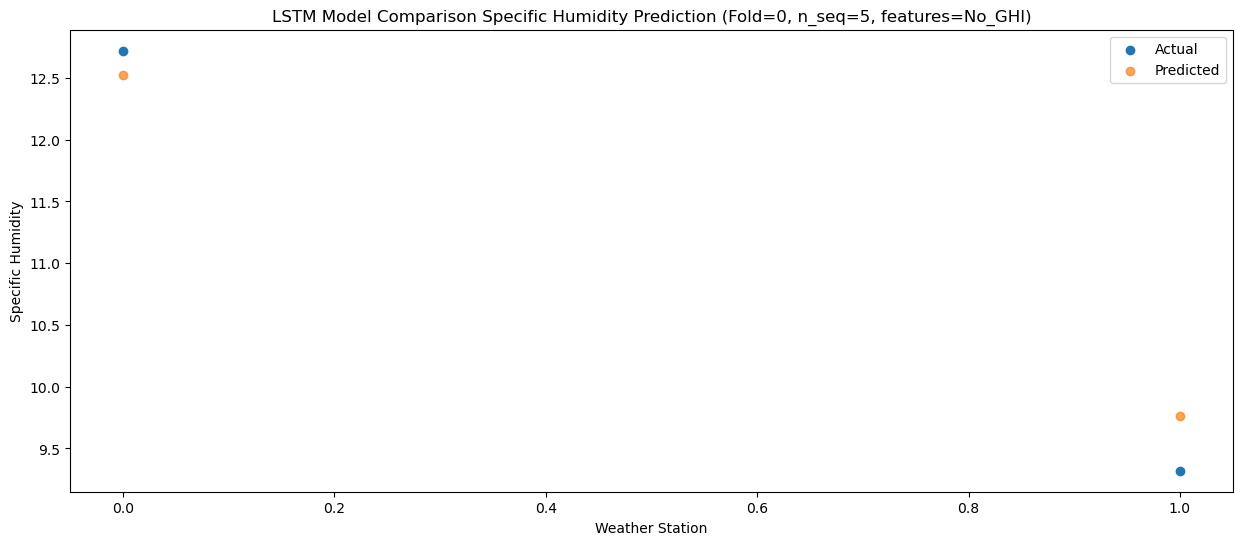

f, t:
[[12.77  9.88]
 [12.89 10.09]
 [12.7   9.65]
 [12.41  9.13]
 [12.72  9.32]]
[[12.46304981  9.71301074]
 [12.46028583  9.71210943]
 [12.62244807  9.87244848]
 [12.22424443  9.47270988]
 [12.5199139   9.76510174]]
Year at t+1:
t+1 SKRMSE: 0.247087
t+1 KRMSE: 0.247087
t+1 MAE: 0.236970
t+1 SKMAPE: 0.020469
t+1 R2_SCORE: 0.970761
t+1 KMAPE: 0.020469
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.325000
Year at t+2:
t+2 SKRMSE: 0.404633
t+2 KRMSE: 0.404633
t+2 MAE: 0.403802
t+2 SKMAPE: 0.035395
t+2 R2_SCORE: 0.916465
t+2 KMAPE: 0.035395
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 11.490000
Year at t+3:
t+3 SKRMSE: 0.166580
t+3 KRMSE: 0.166580
t+3 MAE: 0.150000
t+3 SKMAPE: 0.014579
t+3 R2_SCORE: 0.988068
t+3 KMAPE: 0.014579
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 11.175000
Year at t+4:
t+4 SKRMSE: 0.275640
t+4 KRMSE: 0.275640
t+4 MAE: 0.264233
t+4 SKMAPE: 0.026252
t+4 R2_SCORE: 0.971751
t+4 KMAPE: 0.026252
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 10.770000
Year at t+5:
t+5 SKRMSE: 0.345

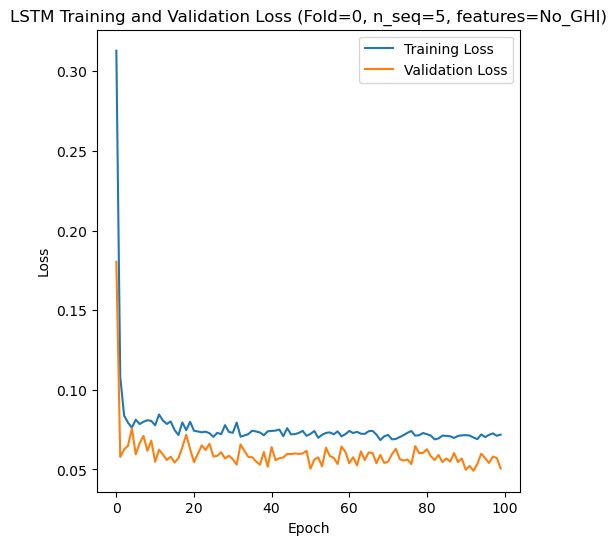

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 5s 84ms/step - loss: 0.3291 - accuracy: 0.1579 - mae: 0.3146 - rmse: 0.3291 - mape: 72.4212 - pearson: 0.3245 - val_loss: 0.1629 - val_accuracy: 0.3333 - val_mae: 0.1459 - val_rmse: 0.1629 - val_mape: 32.8629 - val_pearson: 0.4542
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1059 - accuracy: 0.1579 - mae: 0.0916 - rmse: 0.1059 - mape: 21.3231 - pearson: 0.2526 - val_loss: 0.0767 - val_accuracy: 0.3333 - val_mae: 0.0667 - val_rmse: 0.0767 - val_mape: 17.4422 - val_pearson: 0.4373
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0778 - accuracy: 0.

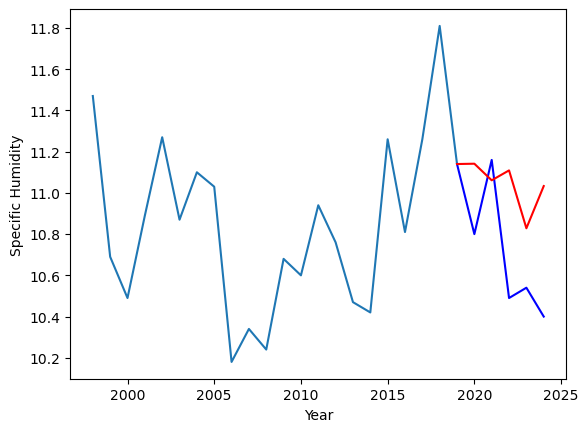

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.66		7.30		-0.36
6.92		7.21		0.29
7.36		7.26		-0.10
6.79		6.97		0.18
6.94		7.18		0.24


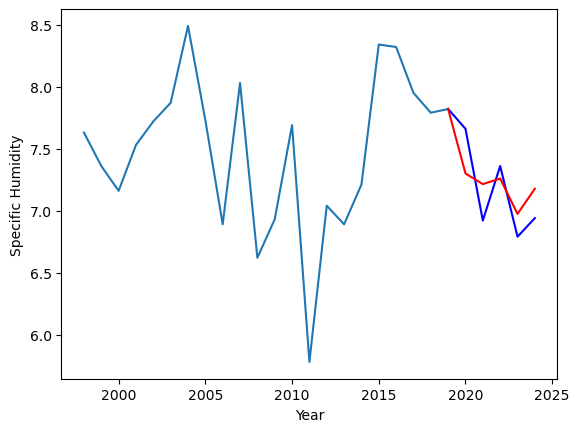

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   10.80  11.141565
1                1    7.66   7.299750


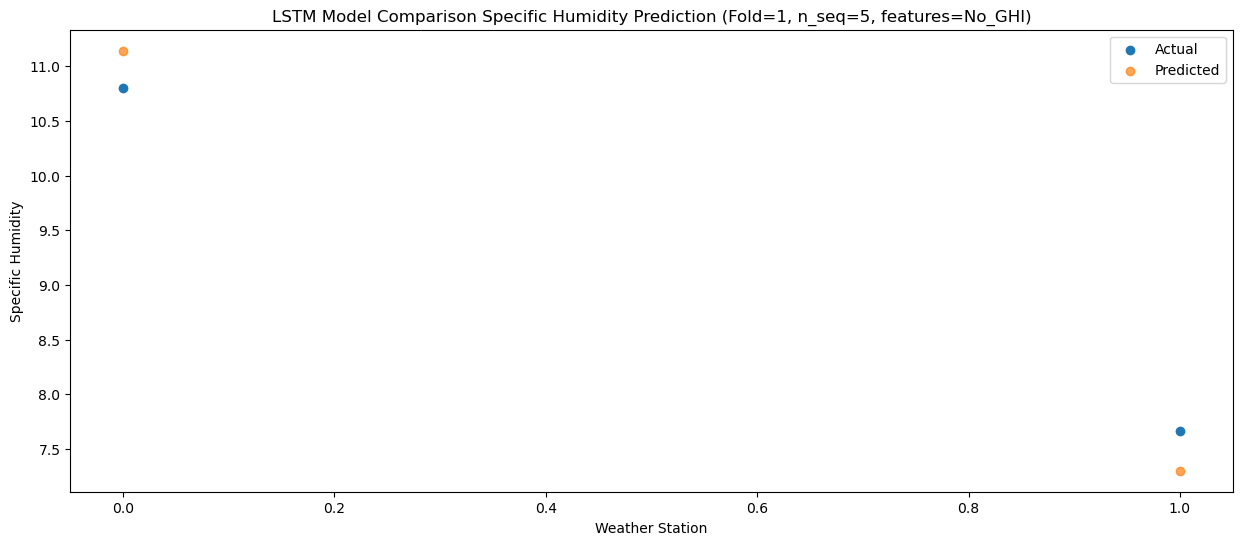

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   11.16  11.061101
1                1    6.92   7.214171


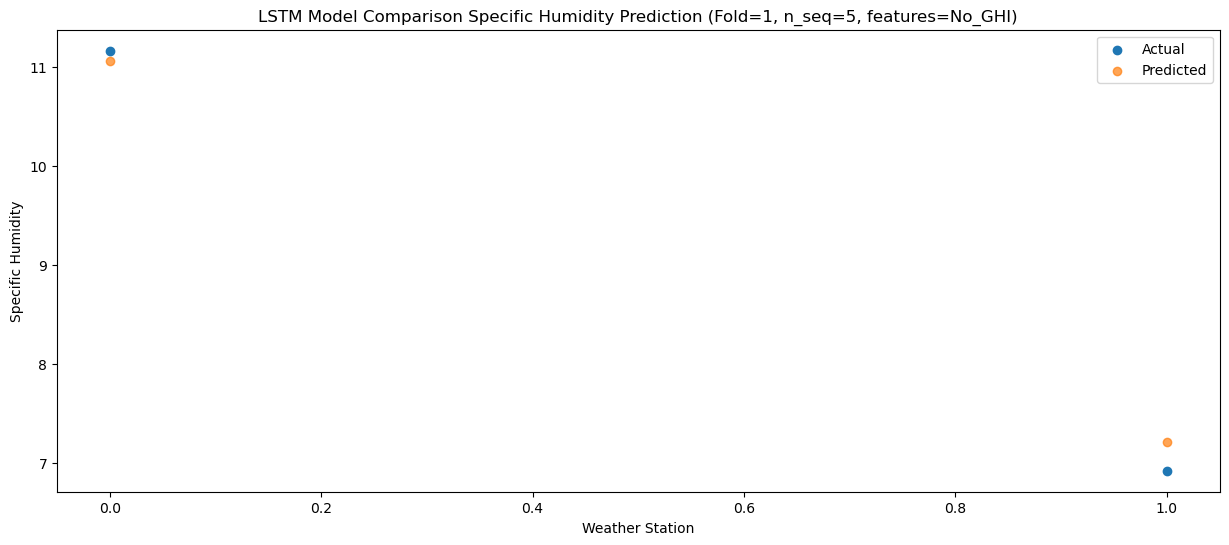

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   10.49  11.109147
1                1    7.36   7.259029


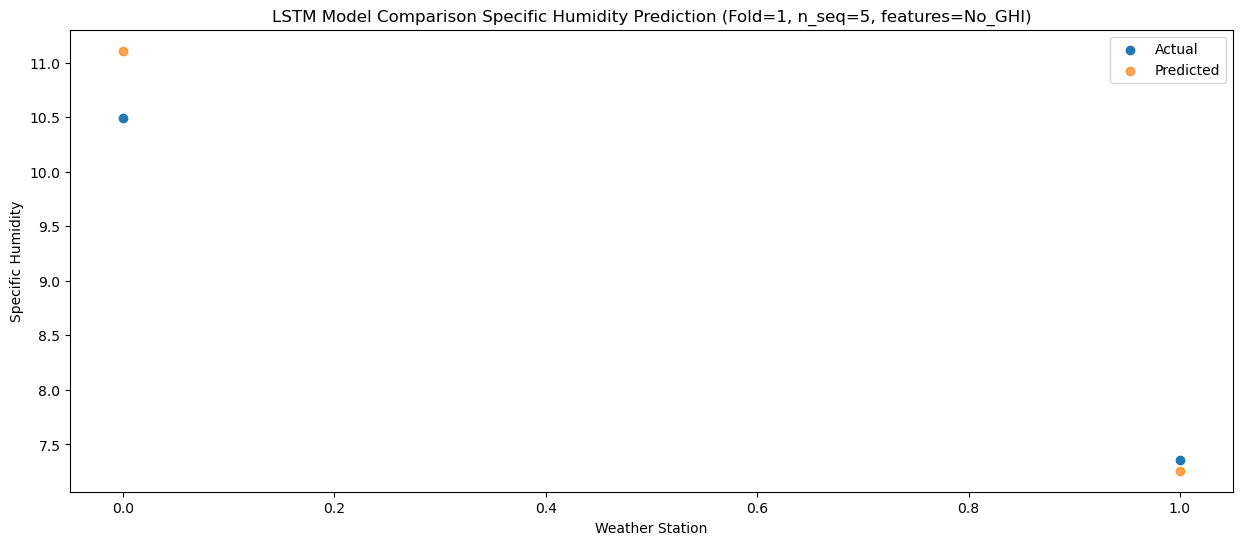

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.54  10.828352
1                1    6.79   6.973730


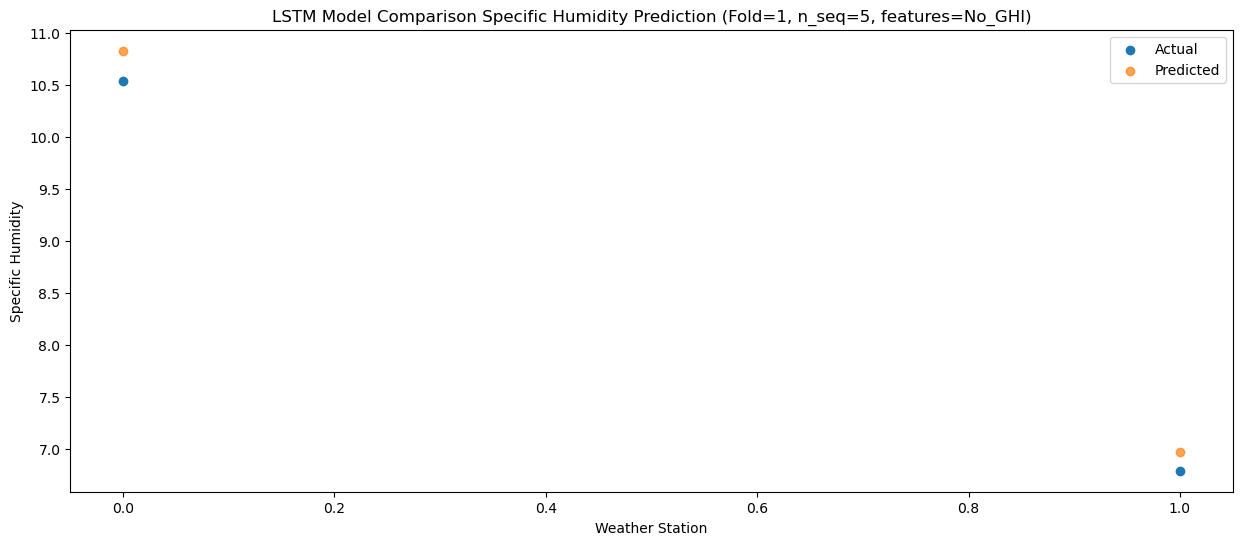

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   10.40  11.033176
1                1    6.94   7.177109


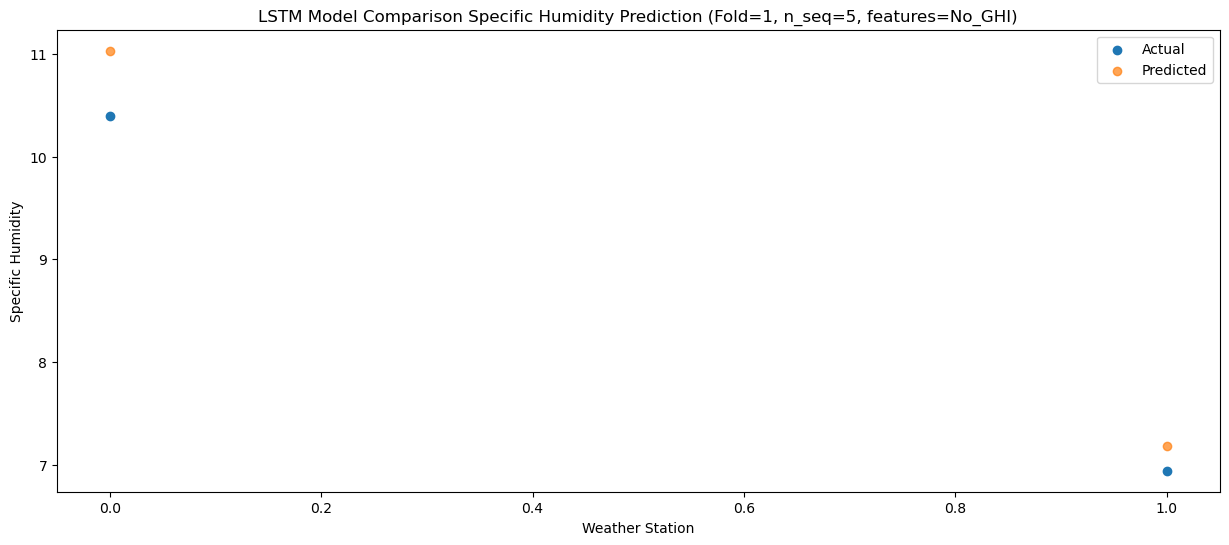

f, t:
[[10.8   7.66]
 [11.16  6.92]
 [10.49  7.36]
 [10.54  6.79]
 [10.4   6.94]]
[[11.1415652   7.29975036]
 [11.06110145  7.21417084]
 [11.10914688  7.25902914]
 [10.82835205  6.97373013]
 [11.03317597  7.17710924]]
Year at t+1:
t+1 SKRMSE: 0.351032
t+1 KRMSE: 0.351032
t+1 MAE: 0.350907
t+1 SKMAPE: 0.039328
t+1 R2_SCORE: 0.950009
t+1 KMAPE: 0.039328
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.230000
Year at t+2:
t+2 SKRMSE: 0.219451
t+2 KRMSE: 0.219451
t+2 MAE: 0.196535
t+2 SKMAPE: 0.025686
t+2 R2_SCORE: 0.989285
t+2 KMAPE: 0.025686
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.040000
Year at t+3:
t+3 SKRMSE: 0.443587
t+3 KRMSE: 0.443587
t+3 MAE: 0.360059
t+3 SKMAPE: 0.036371
t+3 R2_SCORE: 0.919661
t+3 KMAPE: 0.036371
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 8.925000
Year at t+4:
t+4 SKRMSE: 0.241768
t+4 KRMSE: 0.241768
t+4 MAE: 0.236041
t+4 SKMAPE: 0.027208
t+4 R2_SCORE: 0.983374
t+4 KMAPE: 0.027208
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.665000
Year at t+5:
t+5 SKRMSE: 0.478086


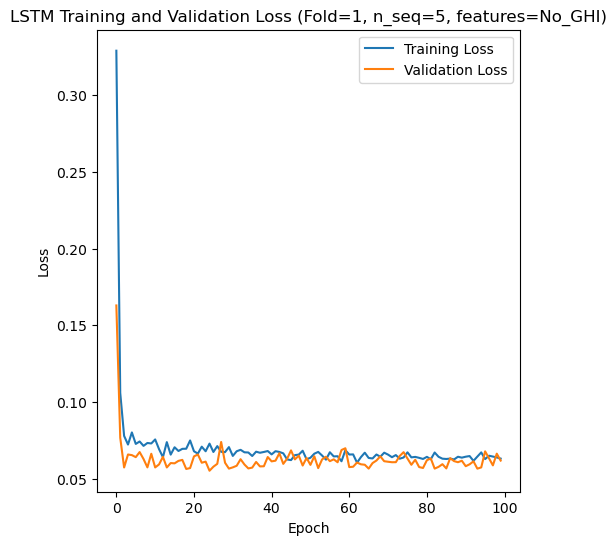

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 5s 84ms/step - loss: 0.2686 - accuracy: 0.3684 - mae: 0.2568 - rmse: 0.2686 - mape: 59.8754 - pearson: 0.2275 - val_loss: 0.0957 - val_accuracy: 0.3333 - val_mae: 0.0796 - val_rmse: 0.0957 - val_mape: 17.8511 - val_pearson: 0.4796
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0856 - accuracy: 0.3684 - mae: 0.0726 - rmse: 0.0856 - mape: 17.6653 - pearson: 0.3493 - val_loss: 0.0728 - val_accuracy: 0.3333 - val_mae: 0.0589 - val_rmse: 0.0728 - val_mape: 14.9702 - val_pearson: 0.5477
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0820 - accuracy: 0.

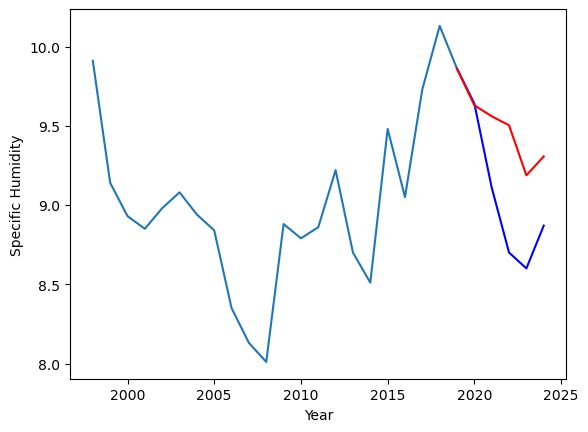

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.84		8.21		0.37
7.66		8.13		0.47
7.73		8.07		0.34
8.00		7.76		-0.24
8.01		7.87		-0.14


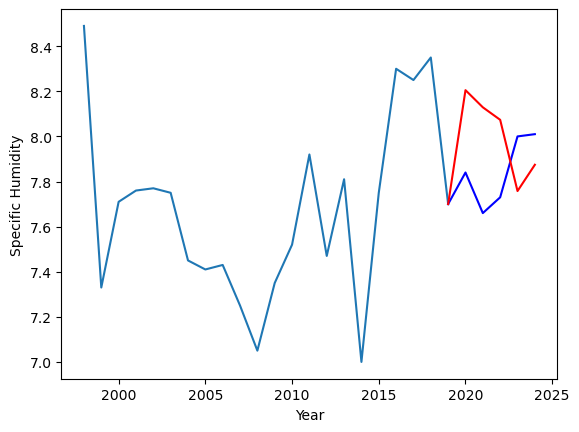

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.64   9.629249
1                1    7.84   8.205126


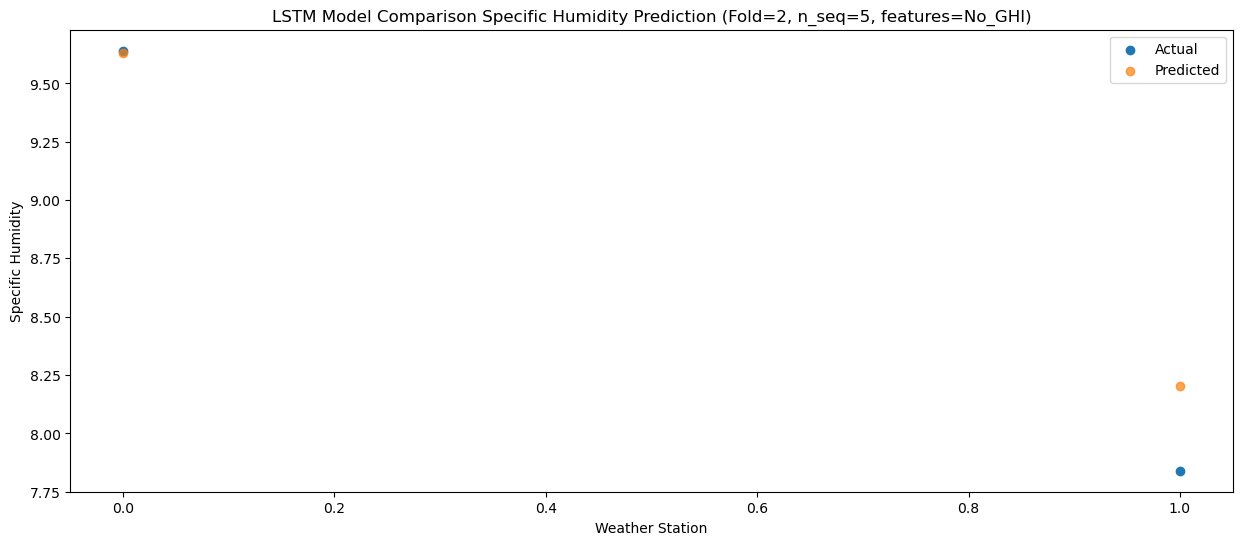

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    9.11   9.560024
1                1    7.66   8.129096


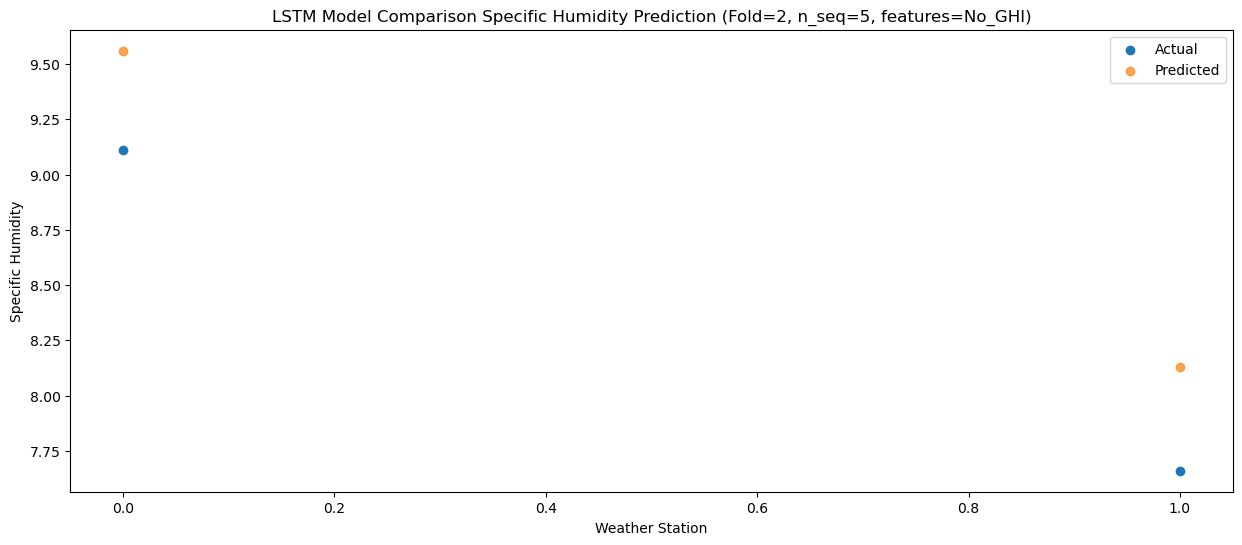

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    8.70   9.502881
1                1    7.73   8.073595


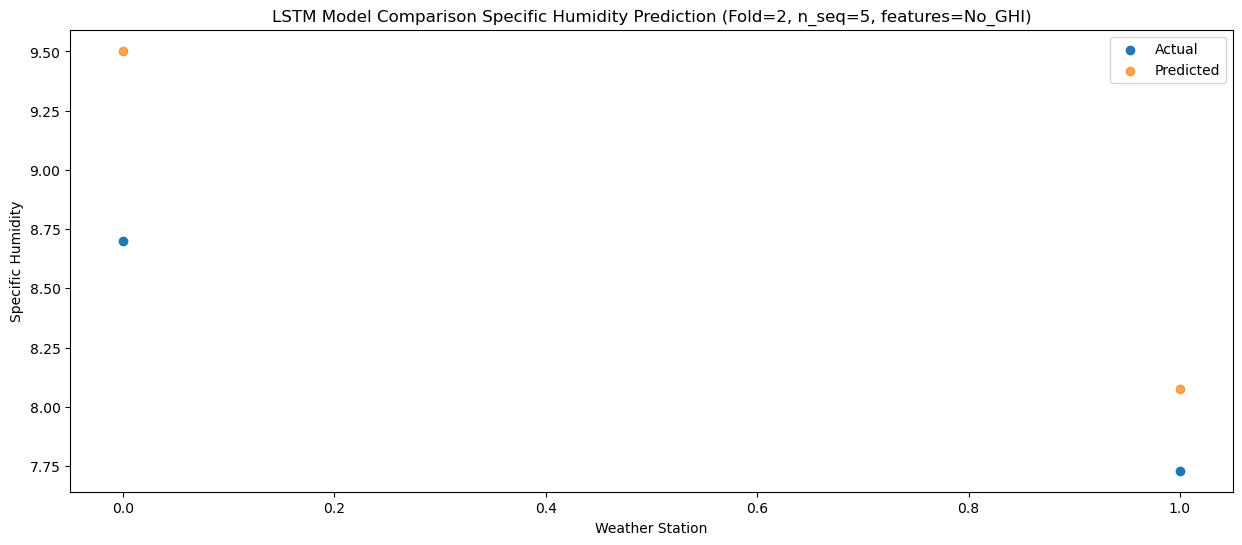

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0     8.6   9.187414
1                1     8.0   7.757762


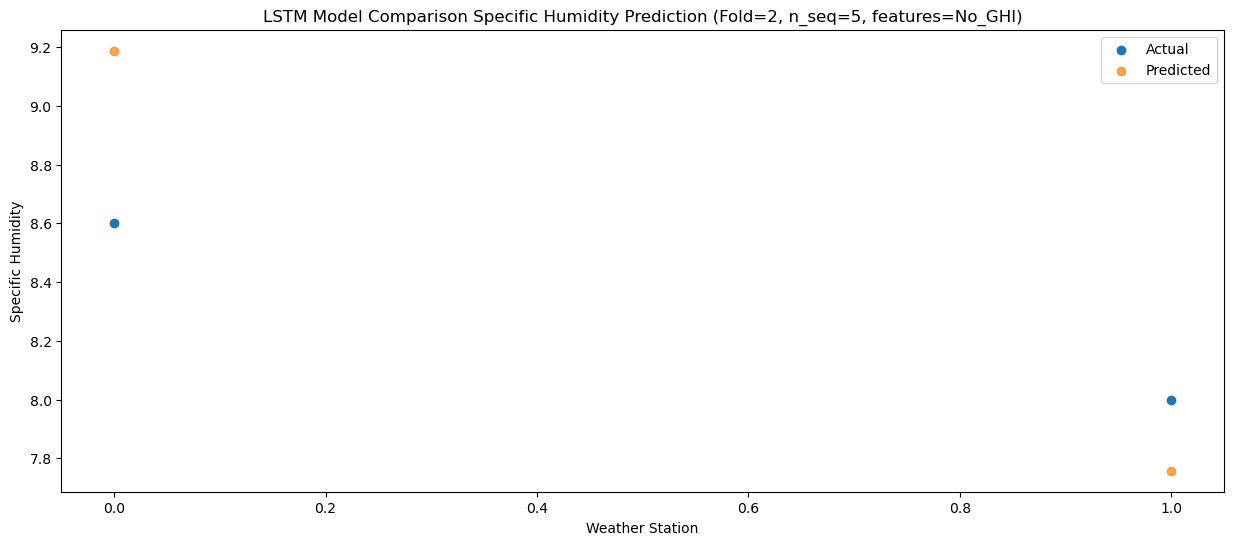

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    8.87   9.306429
1                1    8.01   7.874314


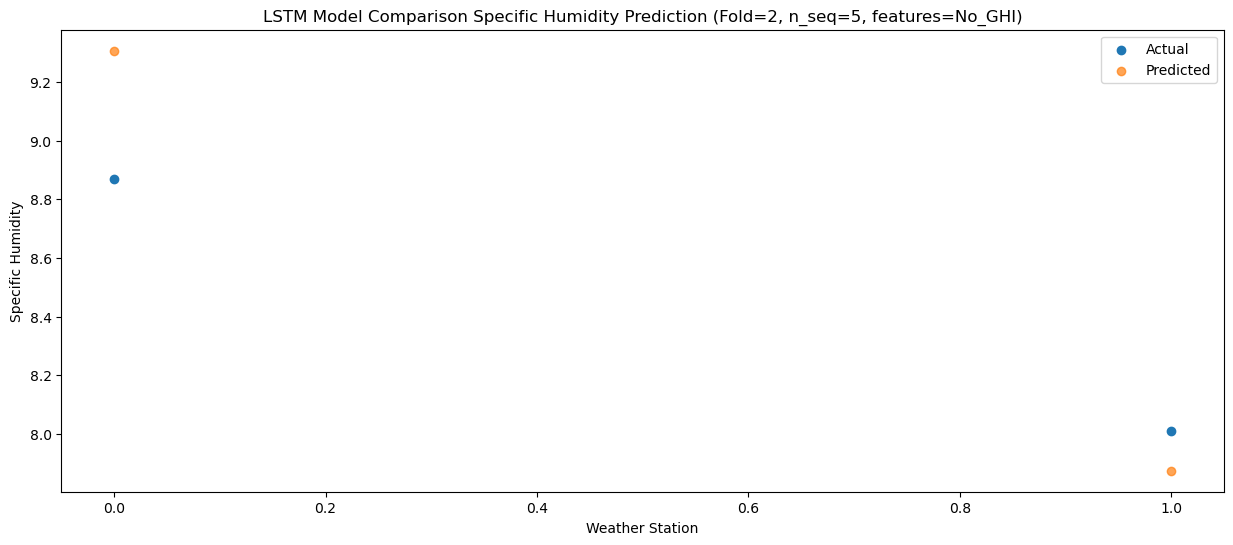

f, t:
[[9.64 7.84]
 [9.11 7.66]
 [8.7  7.73]
 [8.6  8.  ]
 [8.87 8.01]]
[[9.62924853 8.20512601]
 [9.56002367 8.12909557]
 [9.50288143 8.07359538]
 [9.18741443 7.75776232]
 [9.30642912 7.87431447]]
Year at t+1:
t+1 SKRMSE: 0.258295
t+1 KRMSE: 0.258295
t+1 MAE: 0.187939
t+1 SKMAPE: 0.023844
t+1 R2_SCORE: 0.917634
t+1 KMAPE: 0.023844
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 8.740000
Year at t+2:
t+2 SKRMSE: 0.459659
t+2 KRMSE: 0.459659
t+2 MAE: 0.459560
t+2 SKMAPE: 0.055319
t+2 R2_SCORE: 0.598029
t+2 KMAPE: 0.055319
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 8.385000
Year at t+3:
t+3 SKRMSE: 0.617526
t+3 KRMSE: 0.617526
t+3 MAE: 0.573238
t+3 SKMAPE: 0.068367
t+3 R2_SCORE: -0.621164
t+3 KMAPE: 0.068367
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 8.215000
Year at t+4:
t+4 SKRMSE: 0.449297
t+4 KRMSE: 0.449297
t+4 MAE: 0.414826
t+4 SKMAPE: 0.049292
t+4 R2_SCORE: -1.242971
t+4 KMAPE: 0.049292
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.300000
Year at t+5:
t+5 SKRMSE: 0.323173
t+5 KRMSE: 0.32317

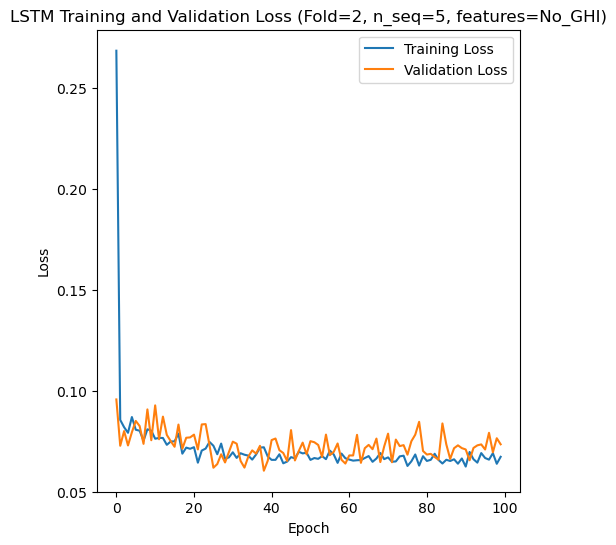

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 5s 74ms/step - loss: 0.4332 - accuracy: 0.2500 - mae: 0.4185 - rmse: 0.4332 - mape: 71.2366 - pearson: 0.2638 - val_loss: 0.2508 - val_accuracy: 0.0000e+00 - val_mae: 0.2412 - val_rmse: 0.2508 - val_mape: 39.2736 - val_pearson: 0.7474
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1354 - accuracy: 0.4000 - mae: 0.1174 - rmse: 0.1354 - mape: 20.3506 - pearson: 0.3514 - val_loss: 0.0851 - val_accuracy: 0.5000 - val_mae: 0.0612 - val_rmse: 0.0851 - val_mape: 10.2815 - val_pearson: 0.5616
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1101 - accuracy: 0.3500 - mae: 0.0910 - rmse: 0.1101 - mape: 16.2491 - pe

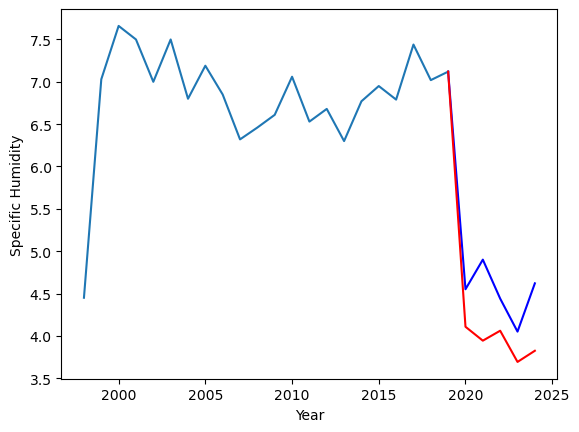

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.21		7.99		-0.22
8.12		7.83		-0.29
8.09		7.94		-0.15
7.62		7.57		-0.05
7.64		7.70		0.06


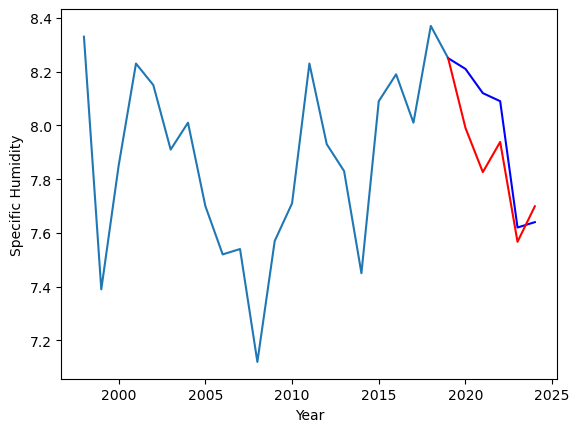

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    4.55   4.107227
1                1    8.21   7.990306


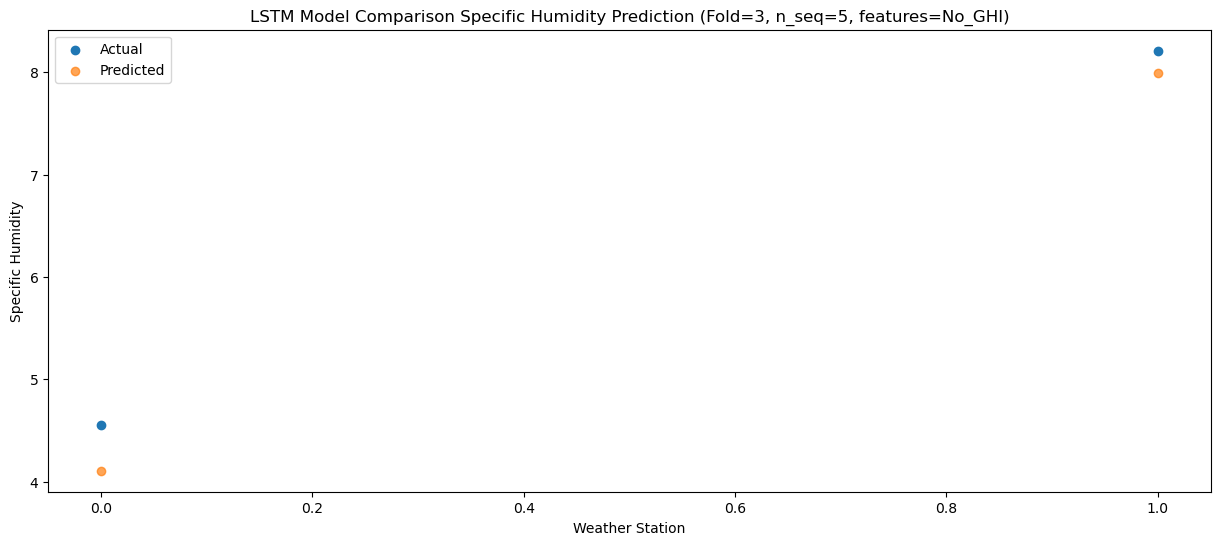

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    4.90   3.943041
1                1    8.12   7.826073


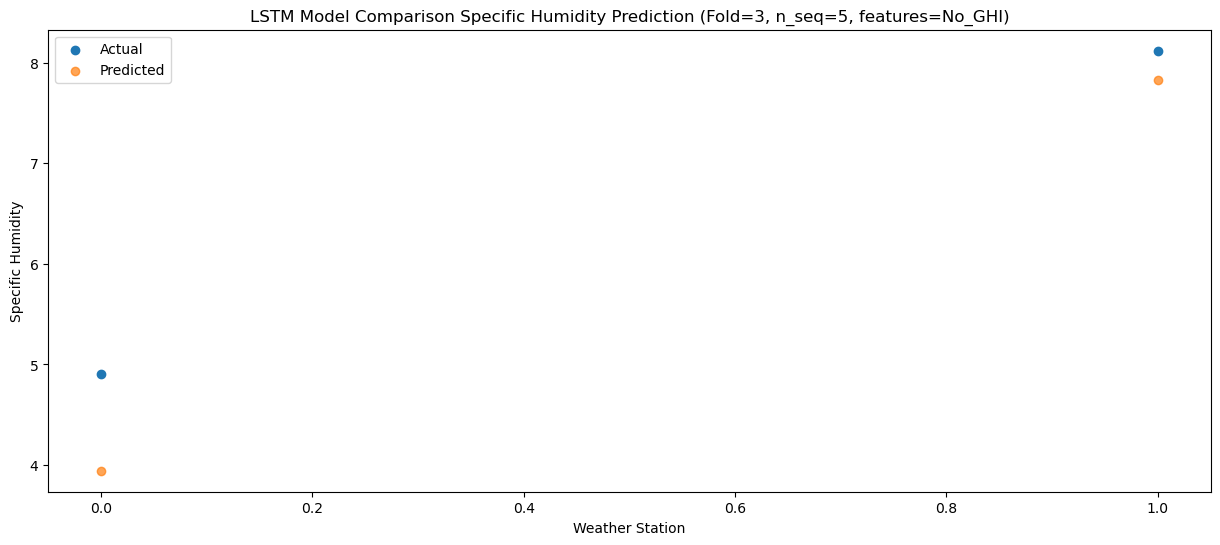

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    4.44   4.060431
1                1    8.09   7.938441


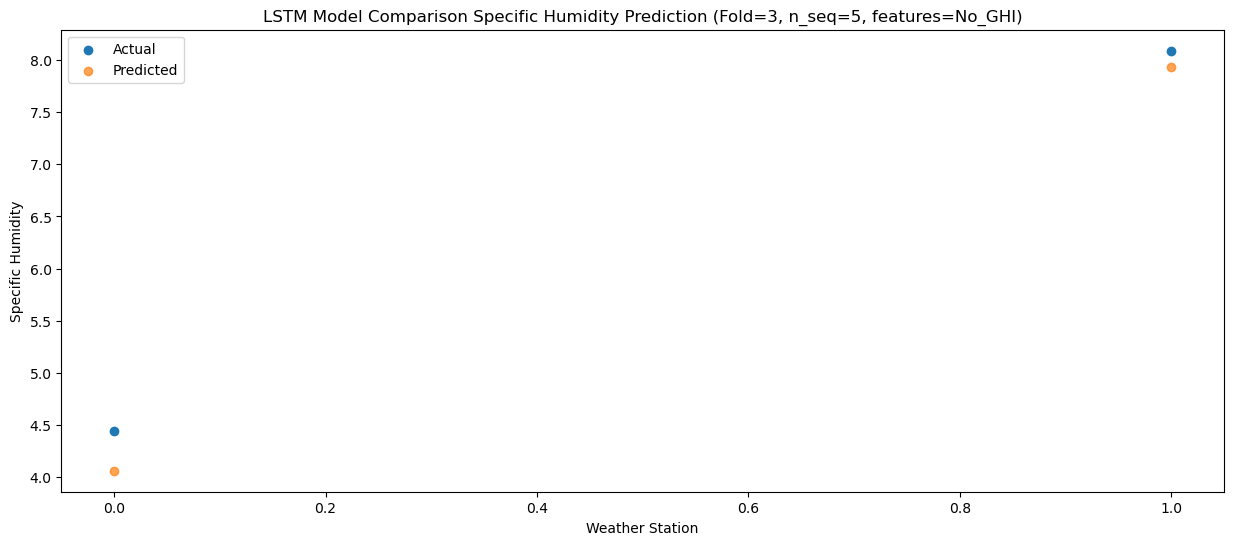

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0    4.05   3.692002
1                1    7.62   7.566936


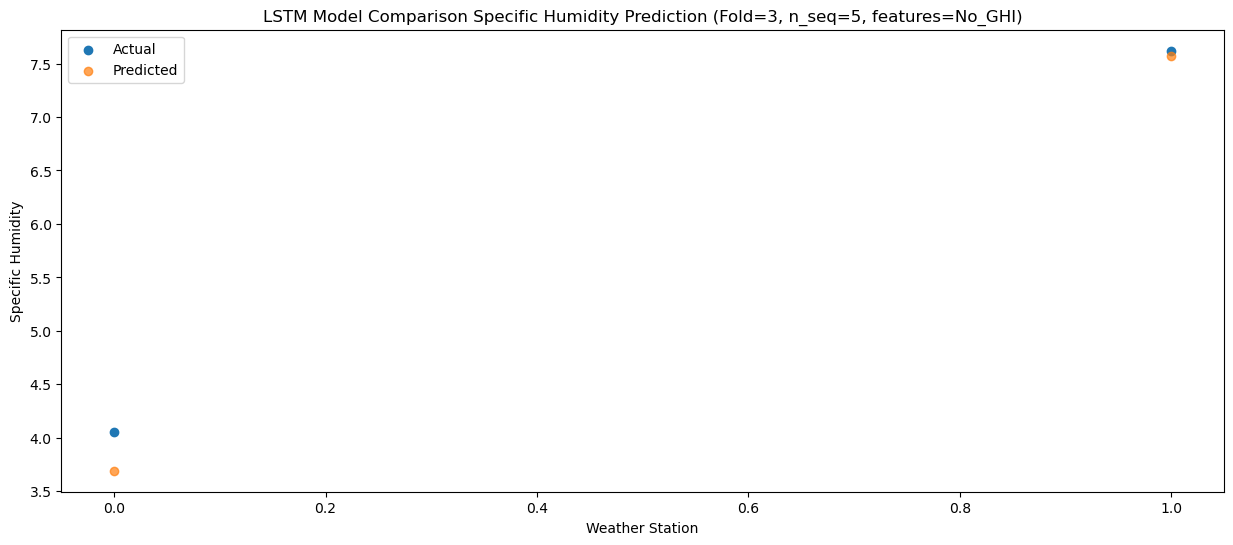

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    4.62   3.823802
1                1    7.64   7.699041


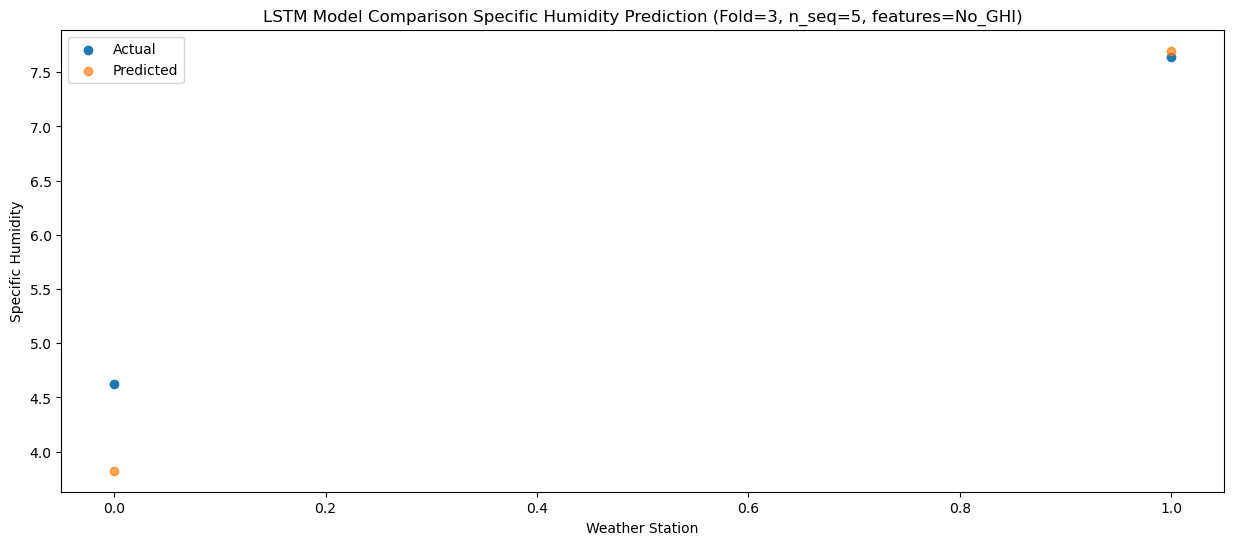

f, t:
[[4.55 8.21]
 [4.9  8.12]
 [4.44 8.09]
 [4.05 7.62]
 [4.62 7.64]]
[[4.10722665 7.99030639]
 [3.94304095 7.8260732 ]
 [4.06043124 7.93844072]
 [3.69200161 7.56693582]
 [3.82380207 7.69904142]]
Year at t+1:
t+1 SKRMSE: 0.349509
t+1 KRMSE: 0.349509
t+1 MAE: 0.331233
t+1 SKMAPE: 0.062036
t+1 R2_SCORE: 0.963523
t+1 KMAPE: 0.062036
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.380000
Year at t+2:
t+2 SKRMSE: 0.707871
t+2 KRMSE: 0.707871
t+2 MAE: 0.625443
t+2 SKMAPE: 0.115748
t+2 R2_SCORE: 0.806689
t+2 KMAPE: 0.115748
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 6.510000
Year at t+3:
t+3 SKRMSE: 0.289001
t+3 KRMSE: 0.289001
t+3 MAE: 0.265564
t+3 SKMAPE: 0.052111
t+3 R2_SCORE: 0.974923
t+3 KMAPE: 0.052111
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 6.265000
Year at t+4:
t+4 SKRMSE: 0.255909
t+4 KRMSE: 0.255909
t+4 MAE: 0.205531
t+4 SKMAPE: 0.047679
t+4 R2_SCORE: 0.979446
t+4 KMAPE: 0.047679
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 5.835000
Year at t+5:
t+5 SKRMSE: 0.564543
t+5 KRMSE: 0.564543


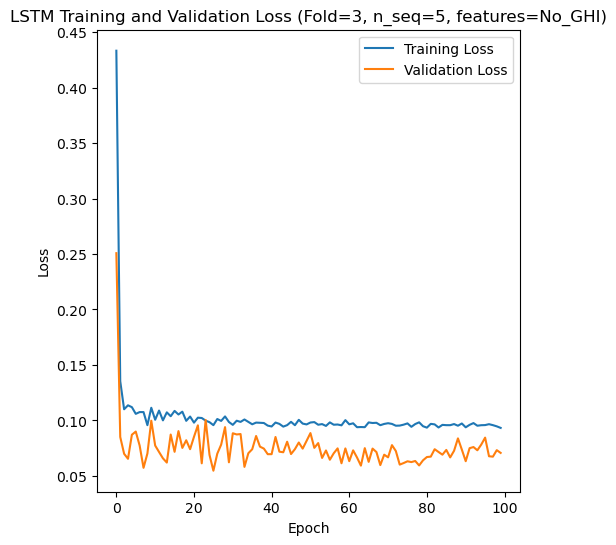

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 5s 83ms/step - loss: 0.2876 - accuracy: 0.3158 - mae: 0.2765 - rmse: 0.2876 - mape: 64.5432 - pearson: 0.2706 - val_loss: 0.1424 - val_accuracy: 0.0000e+00 - val_mae: 0.1226 - val_rmse: 0.1424 - val_mape: 26.6883 - val_pearson: 0.1040
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0845 - accuracy: 0.4211 - mae: 0.0733 - rmse: 0.0845 - mape: 17.4546 - pearson: 0.3423 - val_loss: 0.0888 - val_accuracy: 0.3333 - val_mae: 0.0760 - val_rmse: 0.0888 - val_mape: 17.9649 - val_pearson: 0.2934
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0802 - accuracy:

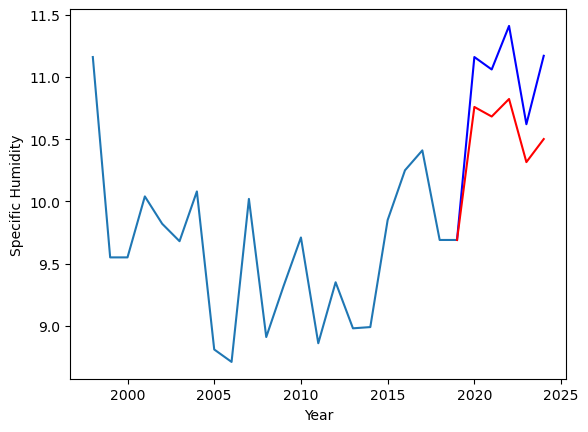

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.79		7.93		0.14
7.52		7.85		0.33
7.85		7.99		0.14
7.25		7.48		0.23
7.48		7.67		0.19


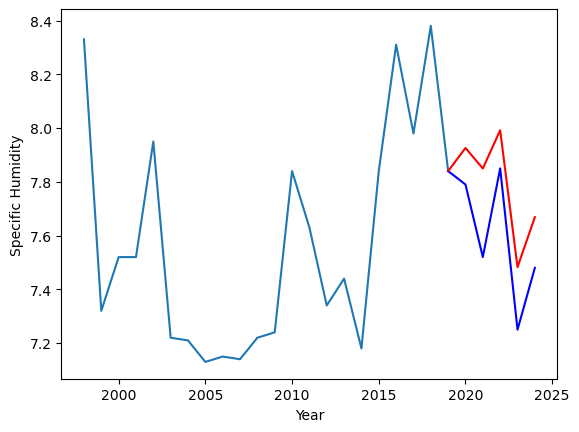

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.16  10.758885
1                1    7.79   7.925918


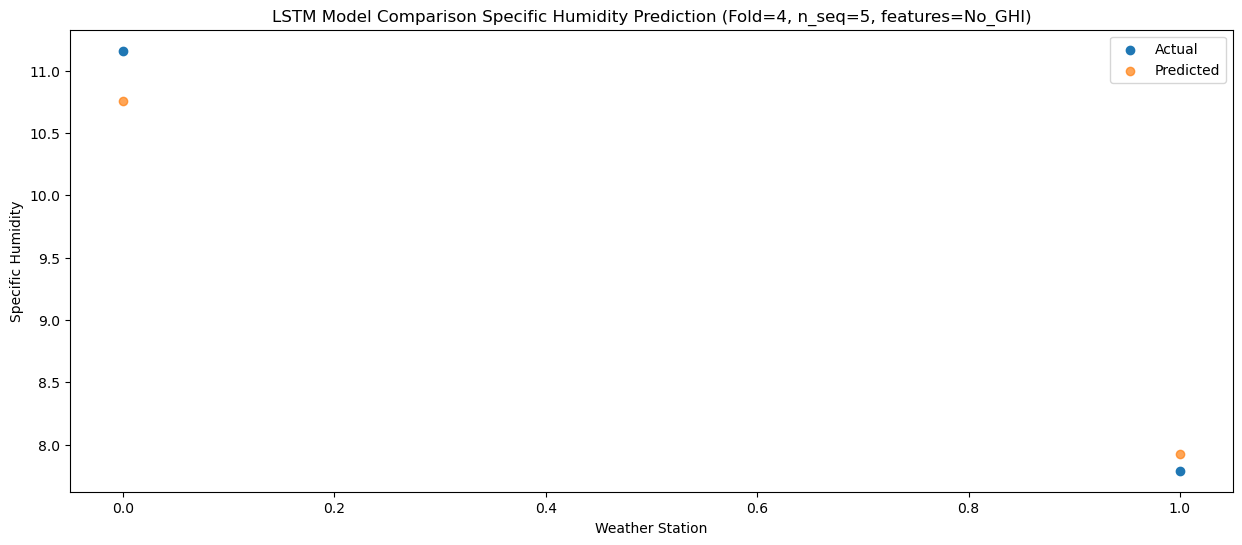

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   11.06  10.681952
1                1    7.52   7.849712


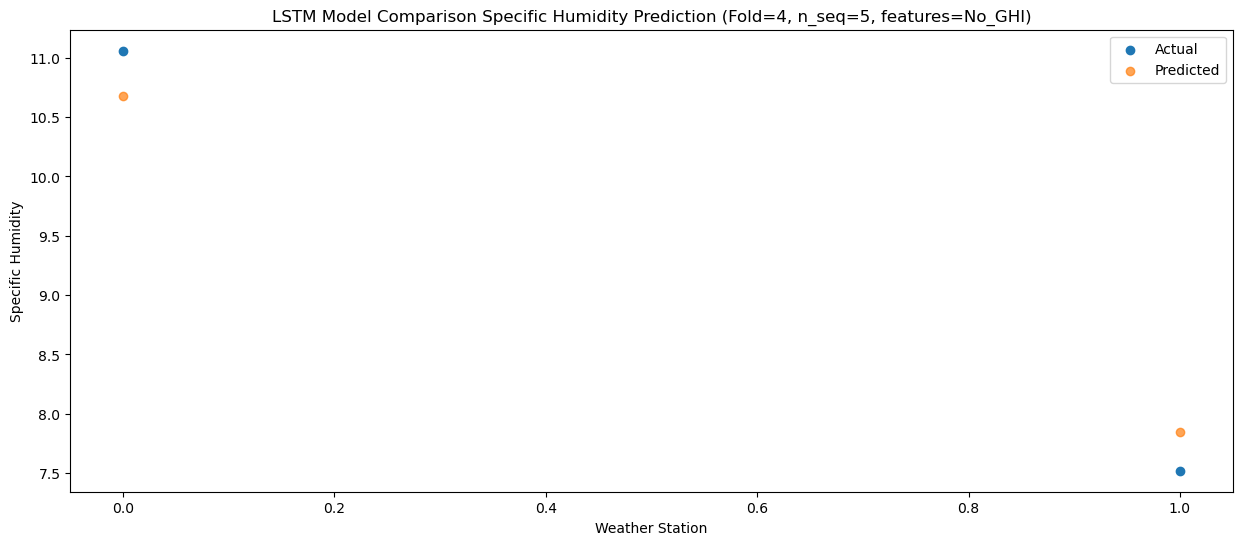

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   11.41  10.822905
1                1    7.85   7.991932


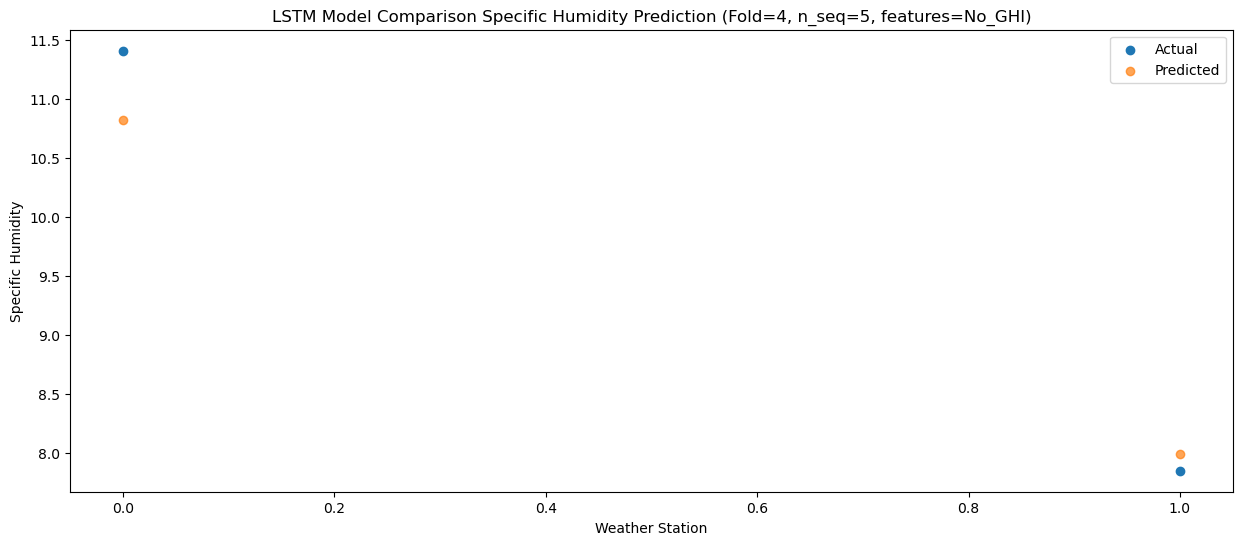

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.62  10.315551
1                1    7.25   7.482565


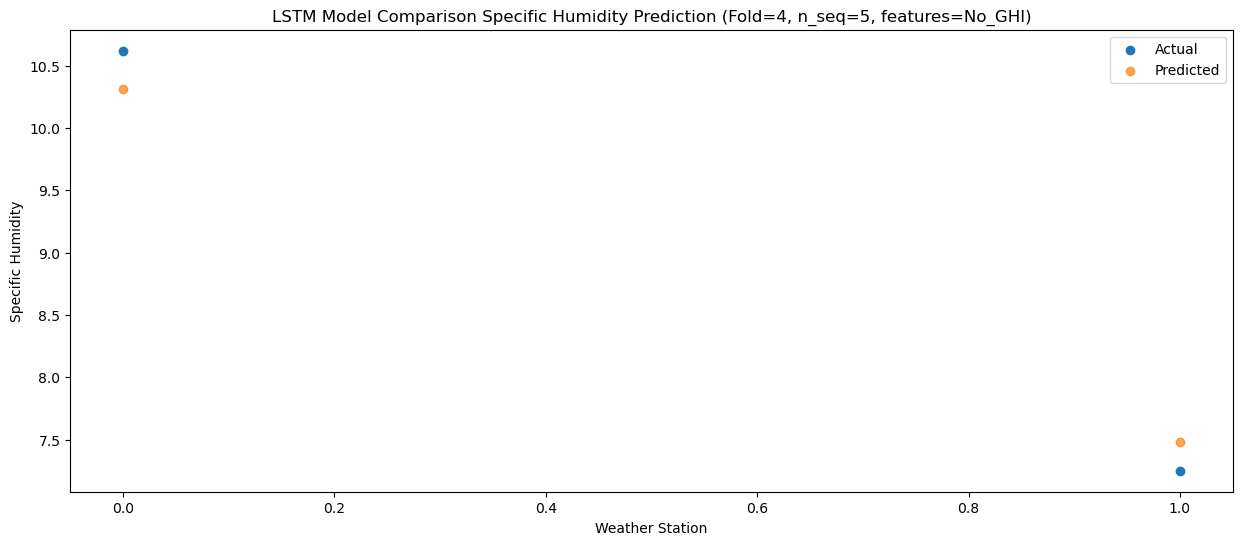

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.17  10.500994
1                1    7.48   7.668632


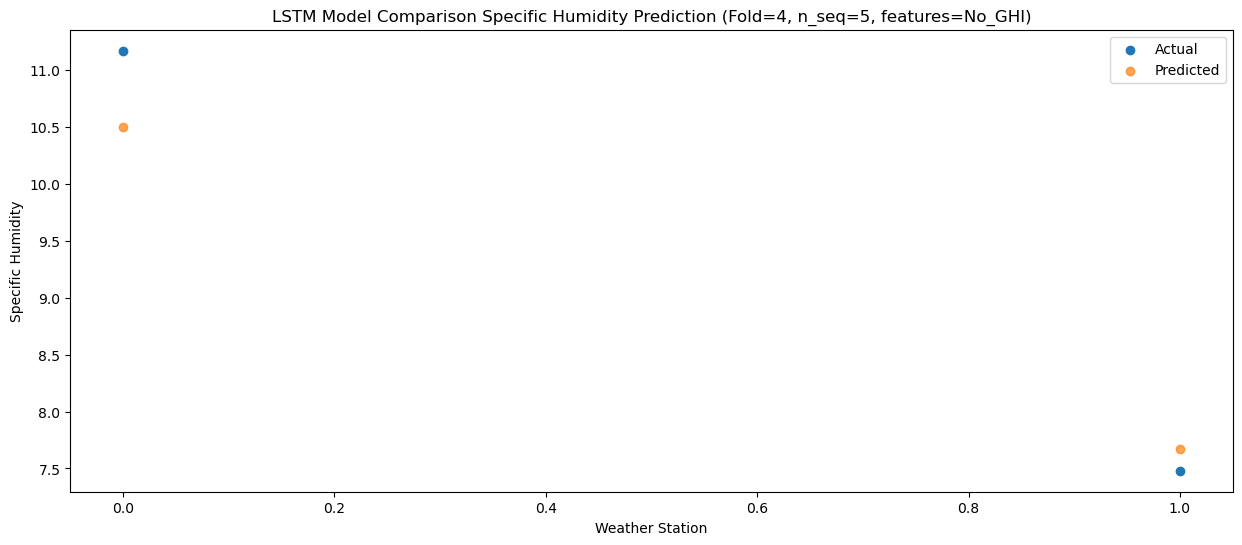

f, t:
[[11.16  7.79]
 [11.06  7.52]
 [11.41  7.85]
 [10.62  7.25]
 [11.17  7.48]]
[[10.75888536  7.92591791]
 [10.68195236  7.84971224]
 [10.82290477  7.9919323 ]
 [10.31555105  7.48256543]
 [10.50099363  7.66863193]]
Year at t+1:
t+1 SKRMSE: 0.299472
t+1 KRMSE: 0.299472
t+1 MAE: 0.268516
t+1 SKMAPE: 0.026695
t+1 R2_SCORE: 0.968413
t+1 KMAPE: 0.026695
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.475000
Year at t+2:
t+2 SKRMSE: 0.354704
t+2 KRMSE: 0.354704
t+2 MAE: 0.353880
t+2 SKMAPE: 0.039013
t+2 R2_SCORE: 0.959841
t+2 KMAPE: 0.039013
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.290000
Year at t+3:
t+3 SKRMSE: 0.427098
t+3 KRMSE: 0.427098
t+3 MAE: 0.364514
t+3 SKMAPE: 0.034767
t+3 R2_SCORE: 0.942427
t+3 KMAPE: 0.034767
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 9.630000
Year at t+4:
t+4 SKRMSE: 0.270902
t+4 KRMSE: 0.270902
t+4 MAE: 0.268507
t+4 SKMAPE: 0.030373
t+4 R2_SCORE: 0.974152
t+4 KMAPE: 0.030373
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.935000
Year at t+5:
t+5 SKRMSE: 0.491504


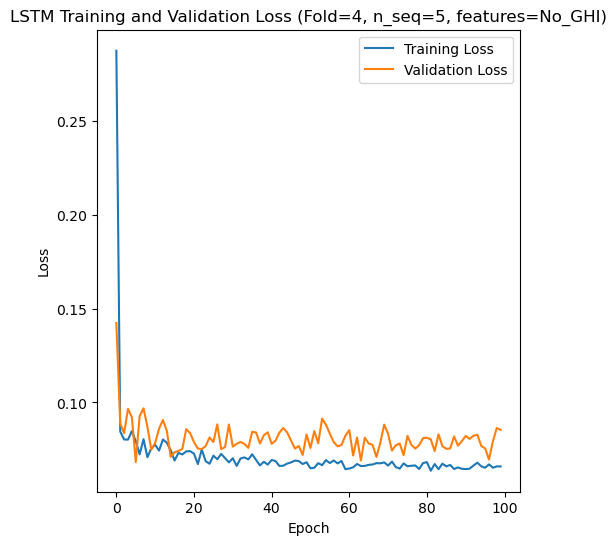

[[0.2991926163069663], [0.3619859443584196], [0.43946520484712115], [0.4671097796070523], [0.3775910194029224]]
[[array(0.29919262)], [array(0.36198594)], [array(0.4394652)], [array(0.46710978)], [array(0.37759102)]]
[[0.27551978981774317], [0.3157369371652603], [0.38432402728497983], [0.37107827749848427], [0.3368472655415539]]
[[0.025687831509173382], [0.035223466075647344], [0.0459786868067223], [0.07352139693805802], [0.03468079568307496]]
[[0.9634962011722293], [0.9594425991904676], [0.5186487690882837], [0.927298177584397], [0.9544560041789836]]
[[array(0.02568783)], [array(0.03522347)], [array(0.04597869)], [array(0.0735214)], [array(0.0346808)]]
[[array(0.97695425)], [array(0.97920705)], [array(0.81741237)], [array(0.98707914)], [array(0.99642836)]]
[12.77 12.89 12.7  12.41 12.72  9.88 10.09  9.65  9.13  9.32 10.8  11.16
 10.49 10.54 10.4   7.66  6.92  7.36  6.79  6.94  9.64  9.11  8.7   8.6
  8.87  7.84  7.66  7.73  8.    8.01  4.55  4.9   4.44  4.05  4.62  8.21
  8.12  8.09  

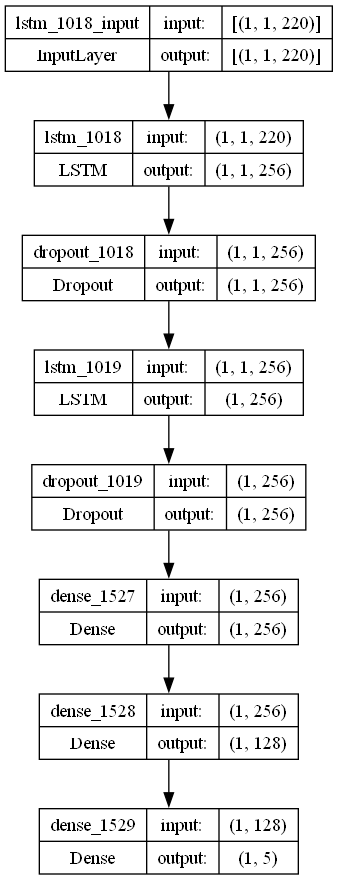

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.03317878285591648 
    optimizer = SGD(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 256
    dropout_rate = 0.4997537949803639

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S5_No_GHI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)